In [1]:
from IPython.display import HTML, Javascript

def restart_run_all():
    display(HTML(
        '''
            <script>
                code_show = false;
                IPython.notebook.kernel.restart();
                setTimeout(function(){
                        IPython.notebook.execute_all_cells();
                    }, 1000)
                
            </script>
        '''
    ))

import ctypes
import gc

def free():
    gc.collect()
    torch.cuda.empty_cache()
    libc = ctypes.CDLL("libc.so.6")
    libc.malloc_trim(0)
    gc.collect()
    torch.cuda.empty_cache()
    libc = ctypes.CDLL("libc.so.6")
    libc.malloc_trim(0)
    
def skip(line, cell=None):
    '''Skips execution of the current line/cell if line evaluates to True.'''
    if eval(line):
        return

    get_ipython().run_cell(cell) 

def load_ipython_extension(shell):
    '''Registers the skip magic when the extension loads.'''
    shell.register_magic_function(skip, 'line_cell')

def unload_ipython_extension(shell):
    '''Unregisters the skip magic when the extension unloads.'''
    del shell.magics_manager.magics['cell']['skip']
    
    
load_ipython_extension(get_ipython())

In [2]:
pipe=2
if pipe==1:
    pipe_name = "Proof_of_concept2"
    X=150
elif pipe==2:
    pipe_name = "HeNe2"
    X=302
elif pipe==3:
    pipe_name = "LED_small_rho2"
    X=422
elif pipe==4:
    pipe_name = "LED_big_rho2"
    X=402



try:
    f = open(f"META_BLOCK_{pipe_name}.txt", "r")
    current_meta_block = int(f.read())
    f.close()
    f = open(f"BLOCK_{pipe_name}.txt", "r")
    current_block = int(f.read())
    f.close()
    f = open(f"SUB_BLOCK_{pipe_name}.txt", "r")
    current_sub_block = int(f.read())
    f.close()
    

except:
    current_block = 1
    current_sub_block = 1
    current_meta_block = 1

if current_meta_block>1:
    hey
    raise ValueError
    
    
print(current_meta_block, current_block, current_sub_block)

1 2 7


In [3]:
if current_meta_block==1: # use only experimental
    dont_use_simulated = True
    dont_use_experimental = False
else: # use noisy or non noisy simulated! 2, 3 respectively
    dont_use_simulated = False
    dont_use_experimental = True

In [4]:
import os
import json as json
import numpy as np
import pandas as pd
import dill
import scipy
import cv2
from SOURCE.CLASS_CODE_Polarization_Obtention_Algorithms import Rotation_Algorithm, Mirror_Flip_Algorithm
from SOURCE.CLASS_CODE_Image_Manager import Image_Manager
from SOURCE.CLASS_CODE_Ad_Hoc_Optimizer import Ad_Hoc_Optimizer
import matplotlib.pyplot as plt
import torch
import h5py
from skimage.filters import threshold_local
from styleframe import StyleFrame
import sklearn as sk

assert torch.cuda.is_available(), "GPU is not enabled"
# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda:0


# PIPELINE TO COMPARE EMBEDDING AND SIMULATOR ALGORITHMS
---
---

    def alg tal (image_refs, image_pbs, save_output_plots_path=None):
        ...
        return predicted_delta_phiCRs, times (de cada pairwise image pair ref pb -que están en los mismos indices claro)

Ke guarde los plots ke se outputean si hace falta en ese path dado.

Ta gero funkiño bat que coja algs, que coja image pairs y si acaso coja sus ground-truths como opctional argument, y que te outputee la tabla de imagen, algoritmos delta phicR, delta pol, times, GT, absolute errors.

Ta gero bebai outputee pa cada algoritmo un histograma de los absolute errors y un histograma de tiempos, con las medias y percentiles indicados correctamente.

In [5]:
import os
import json as json
import numpy as np
import pandas as pd
import cv2
from SOURCE.CLASS_CODE_Polarization_Obtention_Algorithms import Rotation_Algorithm, Mirror_Flip_Algorithm
from SOURCE.CLASS_CODE_Image_Manager import Image_Manager
from SOURCE.CLASS_CODE_Ad_Hoc_Optimizer import Ad_Hoc_Optimizer
import matplotlib.pyplot as plt
import torch
import h5py
from styleframe import StyleFrame

assert torch.cuda.is_available(), "GPU is not enabled"
# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda:0


## Pipeline Functions

In [6]:
def angle_to_pi_pi( angle): # convert any angle to range (-pi,pi]\n",
    angle= angle%(2*np.pi) # take it to [-2pi, 2pi]\n",
    return angle-np.sign(angle)*2*np.pi if abs(angle)>np.pi else angle


def compute_expectation_CI(empirical_pdf, boots_samples, confidence):
    resamplings=np.random.choice(empirical_pdf, size=( boots_samples, empirical_pdf.shape[0]))
    boot_means=np.mean(resamplings, axis=1)
    boot_stds=np.std(resamplings, axis=1)
    observed_mean=empirical_pdf.mean()
    observed_std=empirical_pdf.std()
    boots_t=(observed_mean-boot_means)*np.sqrt(empirical_pdf.shape[0])/boot_stds
    boots_t_percentiles = np.percentile(boots_t, q=((100-confidence)/2, confidence+(100-confidence)/2))
    return observed_mean+boots_t_percentiles*observed_std/np.sqrt(empirical_pdf.shape[0])


def plot_histograms_for(category, variable, final_results_df, statistic_df, conf, output_path, bins_log=True):
    categories=len(final_results_df.groupby([category])) # category sería algorithm
                            # variable serían time, absolute error etc.
    columns=1 if categories==1 else 2 if (categories==2 or categories==4) else 3
    rows=categories//3+(categories%3!=0)

    fig=plt.figure(figsize=(7*columns, 5*rows))
    if bins_log:
        bins_main_exponents=np.linspace(-8.5, -3.5, 32 ).tolist()
        bins_main_exponents=[1]+bins_main_exponents+[-1,0]
        #bins_main_exponents=[1,-8.5, -8, -7.5, -7, -6.5,-6,-5.5,-5,-4.5,-4,-3.5,-1,0]
        bins_main=10**np.array(bins_main_exponents)
        bins_main[0]=0
    else:
        bins_main=13
    axs=[]
    maxy=0
    for i, (group_var_val, group_df) in enumerate(final_results_df.groupby([category])):
        axs.append(fig.add_subplot(rows,columns, i+1))
        ns, b, p = axs[-1].hist(group_df[variable], bins=bins_main,
                        label=f"{category}={group_var_val}", 
                        rwidth=1, align='mid', edgecolor="k", alpha=0.6) # range=(0,0.4)
        if bins_log:
            axs[-1].set_xscale('log')
        axs[-1].grid(True)
        axs[-1].axvline(x=statistic_df[variable][f'CI_{conf}_low'][group_var_val], color='m',
                        linestyle='--', label=f'mean {conf} CI', alpha=0.6)
        axs[-1].axvline(x=statistic_df[variable][f'CI_{conf}_up'][group_var_val], color='m', 
                        linestyle='--', alpha=0.6)
        quantiles=np.percentile(group_df[variable], q=((100-conf)/2, conf+(100-conf)/2))
        axs[-1].axvline(x=quantiles[0], color='r', linestyle='--', label=f'{conf} quantiles')
        axs[-1].axvline(x=quantiles[1], color='r', linestyle='--')
        axs[-1].set_title(f"mu {conf}% CI:\n ({statistic_df[variable][f'CI_{conf}_low'][group_var_val]}, \
                          {statistic_df[variable][f'CI_{conf}_up'][group_var_val]})")
        axs[-1].legend()
        maxy = np.max(ns) if np.max(ns)>maxy else maxy
    for ax in axs:
        ax.set_ylim(0,maxy)
    #fig.supylabel('common_y')
    fig.suptitle(f"Histograms for {variable}")
    #fig.suptitle(f"Histogrms for {variable} \n\n Experiment: {experiment_name}\n\n\n The x axes represent the smallest absolute difference between the theoretical\n angle difference and the found angle difference, among the employed algorithms")

    os.makedirs(f"{output_path}/HISTOGRAMS/", exist_ok=True)
    #fig.tight_layout()
    plt.savefig(f"{output_path}/HISTOGRAMS/Histogram_for_{variable}.png", bbox_inches='tight')
    #plt.close()


times = {}
predicted_delta_phiCRs = {}

def run_benchmark_output_result_histograms_and_result_table( algorithm_lambda_list, algorithm_name_list,
                                            references, problems, image_pair_names, generate_algorithm_plots,
                                            generate_histograms, boots_samples=10000, confidence=95,
                                            output_units='rad', ground_truths=None, GT_units=None,
                                            GT_nature = 'phiCR',
                                            experiment_name = None, output_path=None, batch_size=20):
    if experiment_name is not None:
        output_path = f"{output_path}/{experiment_name}/"
        os.makedirs(output_path, exist_ok=True)
    # GTs should be in [-pi, pi] or [-180, 180]
    global times
    global predicted_delta_phiCRs
    
    conv = 180/np.pi if output_units=='deg' else 1
    convGT = 180/np.pi if (output_units=='deg' and GT_units=='rad') else \
        np.pi/180 if (output_units=='rad' and GT_units=='deg') else 1
    print("> Passing Images from each Algorithm...")
    for algorithm, alg_name in zip(algorithm_lambda_list, algorithm_name_list):
        if output_path is not None and generate_algorithm_plots:
            dir_for_alg = output_path+f"/{alg_name}/"
            os.makedirs( dir_for_alg, exist_ok=True )
        else:
            dir_for_alg = None
        
        predicted_delta_phiCRs[alg_name]={}
        times[alg_name]={}
        #try: # por si por ejemplo ransac no encuentra ningun consenso y salta un error
        for j in range(0, references.shape[0], batch_size):
            
            batch_predicted_delta_phiCRs, batch_times =  algorithm(
                    references[j:(j+batch_size)], problems[j:(j+batch_size)], 
                    image_pair_names[j:(j+batch_size)], dir_for_alg)
            predicted_delta_phiCRs[alg_name].update(batch_predicted_delta_phiCRs)
            times[alg_name].update(batch_times)
            free()
            print(f"Processed {j} Samples")
        '''
        except:
            for imn in image_pair_names:
                predicted_delta_phiCRs[alg_name][imn]=0
                times[alg_name][imn]=0
        '''
        
        print(f" - Algorithm {alg_name} done!")
        try: # for the Carles algorithm to receive different arguments with a lambda function, en fin
            global k
            k+=1
        except:
            pass
        free()
        
    print("\n> Rearranging results in Tables and outputting to Excels...")
    if output_path is not None:
        json.dump({'image_pair_names':image_pair_names, 'predicted_delta_phiCRs':predicted_delta_phiCRs,
              'times':times}, open( f"{output_path}/RAW_results.json", "w"))
    # Rearrange the result to our desired Table and unit formats
    image_ids = []
    image_names = []
    algorithm_names = []
    delta_phiCRs = []
    delta_pols = []
    timess = []
    GTs = []
    abs_errors = []
    free()
    switch_dif = 90 if output_units=='deg' else np.pi/2
    max_diff = 2*switch_dif
    # if abs dif is bigger than 90 then the true error is 180-that number for its the smallest plane difference in angle!
    for idx, image_pair_name in enumerate(image_pair_names):
        for algorithm, alg_name in zip(algorithm_lambda_list, algorithm_name_list):
            image_ids.append(idx)
            algorithm_names.append(alg_name)
            image_names.append(image_pair_name)
            delta_phiCRs.append( conv*angle_to_pi_pi(predicted_delta_phiCRs[alg_name][image_pair_name]) ) 
            delta_pols.append( conv*angle_to_pi_pi(predicted_delta_phiCRs[alg_name][image_pair_name])/2.0 )
            timess.append(times[alg_name][image_pair_name])
            if ground_truths is not None:
                GTs.append(convGT*ground_truths[idx])
                if GT_nature=='phiCR':
                    abs_errors.append( np.abs(delta_phiCRs[-1]-convGT*ground_truths[idx]) )
                else: # then GT is of polarization
                    abs_dif = np.abs(delta_pols[-1]-convGT*ground_truths[idx])
                    if abs_dif>switch_dif:
                        abs_er = max_diff - abs_dif
                    else:
                        abs_er = abs_dif
                    abs_errors.append( abs_er )
                #correct_decimals.append() # beittu HISTOGRAMAGAZ batera zelan eitten zendun hau!
    table_per_image = pd.DataFrame.from_dict({'ID':image_ids, 'Image_Pair_Name':image_names, 'Algorithm':algorithm_names,
                                   'Predicted_Delta_PhiCRs':delta_phiCRs, 'Pred_Delta_Polarizt':delta_pols,
                                   'Times':timess, f'Ground_Truth_{GT_nature}':GTs, 'Absolute_Error':abs_errors})
    if output_path is not None:
        table_per_image.to_pickle( f"{output_path}/Table_Per_Image_All.pkl")
    print(" - Table per images done!")    
    free()

    # Group by algorithm and generate statistics by analyte (times, absolute_errors etc.)
    groups = table_per_image.groupby('Algorithm')
    stdv = groups[['Absolute_Error', 'Times']].std().fillna(0.0)
    means = groups[['Absolute_Error', 'Times']].mean()
    # Compute confidence intervals using bootstrap
    CIs_time = {}
    CIs_abs_er = {}
    for alg_name, df in table_per_image.groupby('Algorithm'):
        CIs_time[alg_name] = compute_expectation_CI(df['Times'],boots_samples, confidence)
        CIs_abs_er[alg_name] = compute_expectation_CI(df['Absolute_Error'], boots_samples, confidence)
        free()
    CIs_time_df = pd.DataFrame(index=CIs_time.keys(), data=CIs_time.values(), columns=[f'CI_{confidence}_l', f'CI_{confidence}_u'])
    CIs_abs_er_df = pd.DataFrame(index=CIs_abs_er.keys(), data=CIs_abs_er.values(), columns=[f'CI_{confidence}_l', f'CI_{confidence}_u'])
    
    ae = pd.concat([means['Absolute_Error'], stdv['Absolute_Error'],
                    CIs_abs_er_df[f'CI_{confidence}_l'], CIs_abs_er_df[f'CI_{confidence}_u']],
                   keys=['Mean', 'Standard_Dev', f'CI_{confidence}_low', f'CI_{confidence}_up'],axis=1)
    ts = pd.concat([means['Times'], stdv['Times'],
                    CIs_time_df[f'CI_{confidence}_l'], CIs_time_df[f'CI_{confidence}_u']],                   
                   keys=['Mean', 'Standard_Dev', f'CI_{confidence}_low', f'CI_{confidence}_up'],axis=1)
    table_per_alg = pd.concat([ae, ts], keys=['Absolute_Error', 'Times'], axis=1)    
    free()

    if output_path is not None:
        table_per_image.to_pickle( f"{output_path}/Table_Per_Algorithm_Statistics.pkl")
        print(" - Table per algorithm done!")    
        if generate_histograms:
            print("\n> Generating histograms...")
            plot_histograms_for('Algorithm', 'Absolute_Error', table_per_image, table_per_alg, confidence, output_path, bins_log=False)
            plot_histograms_for('Algorithm', 'Times', table_per_image, table_per_alg, confidence, output_path, bins_log=False)
            print("DONE!")
    return table_per_image, table_per_alg

# Generic Routines

In [7]:
def compute_intensity_gravity_center(image):
    """
        Expects input image to be an array of dimensions [h, w].
        It will return an array of gravity centers [2(h,w)] in pixel coordinates
        Remember that pixel coordinates are set equal to numpy indices

    """
    # image wise total intensity and marginalized inensities for weighted sum
    intensity_in_w = np.sum(image, axis=0) # weights for x [raw_width]
    intensity_in_h = np.sum(image, axis=1) # weights for y [raw_height]
    total_intensity = intensity_in_h.sum()

    # Compute mass center for intensity
    # [2] (h_center,w_center)
    return np.nan_to_num( np.stack(
        (np.dot(intensity_in_h, np.arange(image.shape[0]))/total_intensity,
         np.dot(intensity_in_w, np.arange(image.shape[1]))/total_intensity)
        ) )

def compute_raw_to_centered_iX(image, X):

    g_raw = compute_intensity_gravity_center(image)
    # crop the iamges with size (X+1+X)^2 leaving the gravity center in
    # the central pixel of the image. In case the image is not big enough for the cropping,
    # a 0 padding will be made.
    centered_image = np.zeros( (2*X+1, 2*X+1),  dtype = image.dtype )

    # we round the gravity centers to the nearest pixel indices
    g_index_raw = np.rint(g_raw).astype(int) #[N_images, 2]

    # obtain the slicing indices around the center of gravity
    # TODO -> make all this with a single array operation by stacking the lower and upper in
    # a new axis!!
    # [ 2 (h,w)]
    unclipped_lower = g_index_raw[:]-X
    unclipped_upper = g_index_raw[:]+X+1
    # unclippde could get out of bounds for the indices, so we clip them
    lower_bound = np.clip( unclipped_lower, a_min=0, a_max=image.shape)
    upper_bound = np.clip( unclipped_upper, a_min=0, a_max=image.shape)
    # we use the difference between the clipped and unclipped to get the necessary padding
    # such that the center of gravity is left still in the center of the image
    padding_lower = lower_bound-unclipped_lower
    padding_upper = upper_bound-unclipped_upper

    # crop the image
    centered_image[padding_lower[0]:padding_upper[0] or None,
                                    padding_lower[1]:padding_upper[1] or None ] = \
                  image[lower_bound[0]:upper_bound[0],
                                      lower_bound[1]:upper_bound[1]]
    return centered_image



def compute_intensity_gravity_centers_torch( images):
    """
        Expects input image to be an array of dimensions [N_imgs, h, w].
        It will return an array of gravity centers [N_imgs, 2(h,w)] in pixel coordinates
        Remember that pixel coordinates are set equal to array indices

    """
    # image wise total intensity and marginalized inensities for weighted sum
    intensity_in_w = torch.sum(images, dim=1) # weights for x [N_images, raw_width]
    intensity_in_h = torch.sum(images, dim=2) # weights for y [N_images, raw_height]
    total_intensity = intensity_in_h.sum(dim=1) # [N_images]

    # Compute mass center for intensity
    # [N_images, 2] (h_center,w_center)
    return torch.nan_to_num( torch.stack(
        (torch.matmul(intensity_in_h.float(), torch.arange(images.shape[1], 
                                    dtype=torch.float32, device=device))/total_intensity,
         torch.matmul(intensity_in_w.float(), torch.arange(images.shape[2], 
                                    dtype=torch.float32, device=device))/total_intensity),
        dim=1
        ), nan=0.0, posinf=None, neginf=None)


def compute_raws_to_centered_iXs_torch( images, X, device):

    g_raw = compute_intensity_gravity_centers_torch(images) # [ N_images, 2]

    # crop the iamges with size (X+1+X)^2 leaving the gravity center in
    # the central pixel of the image. In case the image is not big enough for the cropping,
    # a 0 padding will be made.
    centered_images = torch.zeros( ( images.shape[0], 2*X+1, 2*X+1),  dtype = images.dtype, 
                                  device=device)

    # we round the gravity centers to the nearest pixel indices
    g_index_raw = torch.round(g_raw).int() #[ N_images, 2]

    # obtain the slicing indices around the center of gravity
    # TODO -> make all this with a single array operation by stacking the lower and upper in
    # a new axis!!
    # [ N_images, 2 (h,w)]
    unclipped_lower = g_index_raw-X
    unclipped_upper = g_index_raw+X+1

    # unclipped could get out of bounds for the indices, so we clip them
    lower_bound = torch.clip( unclipped_lower.float(), min=torch.Tensor([[0,0]]).to(device),
                             max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(device)).int()
    upper_bound = torch.clip( unclipped_upper.float(), min=torch.Tensor([[0,0]]).to(device),
                             max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(device)).int()
    # we use the difference between the clipped and unclipped to get the necessary padding
    # such that the center of gravity is left still in the center of the image
    padding_lower = lower_bound-unclipped_lower
    padding_upper = upper_bound-unclipped_upper

    # crop the image
    for im in range(g_raw.shape[0]):
        centered_images[im, padding_lower[ im, 0]:padding_upper[ im, 0] or None,
                                    padding_lower[ im, 1]:padding_upper[ im, 1] or None] = \
                  images[im, lower_bound[ im, 0]:upper_bound[ im, 0],
                                      lower_bound[ im, 1]:upper_bound[ im, 1]]

    return centered_images

# PRE-PROCESSING FUNCTIONS

## Numpy in out

In [8]:
def normalize_to_max_saturate_and_iX(images,  saturation_threshold, dtype=np.float64,
                              iX_dev='cpu', out_dev='cpu', X=X): # threshold is in [0,1] of max
                                                              # images expected to be [N_images, h, w]
    images = images.astype(dtype)
    maxs = np.expand_dims( np.amax(images, axis=(-2,-1) ), (-2,-1) )
    images = np.where(images<maxs*saturation_threshold, images, 0.0)/maxs
    return compute_raws_to_centered_iXs_torch( torch.from_numpy(images).to(device), X, device).to('cpu').numpy()

def normalize_to_mean_saturate_to_max_and_iX(images,  saturation_threshold, dtype=np.float64,
                                     iX_dev='cpu', out_dev='cpu', X=X):  # threshold is in [0,1] of max
                                                                # images expected to be [N_images, h, w]
    images = images.astype(dtype)
    maxs = np.expand_dims( np.amax(images, axis=(-2,-1) ), (-2,-1) )
    images = np.where(images<maxs*saturation_threshold, images, 0.0)/np.expand_dims( np.mean(images, axis=(-2,-1) ), (-2,-1) )
    return compute_raws_to_centered_iXs_torch( torch.from_numpy(images).to(device), X, device).to('cpu').numpy()

def normalize_to_mean_saturate_to_mean_and_iX(images,  saturation_threshold, dtype=np.float64,
                                      iX_dev='cpu', out_dev='cpu', X=X):  # threshold is in [0,1] of max
                                                                # images expected to be [N_images, h, w]
    images = images.astype(dtype)
    means = np.expand_dims( np.mean(images, axis=(-2,-1) ), (-2,-1) )
    images = np.where(images<means*saturation_threshold, images, 0.0)/means
    return compute_raws_to_centered_iXs_torch( torch.from_numpy(images).to(device), X, device).to('cpu').numpy()

def normalize_to_max_and_iX(images, dtype=np.float64,
                    iX_dev='cpu', out_dev='cpu', X=X): # images expected to be [N_images, h, w]
    images= images.astype(dtype)/np.expand_dims( np.amax(images, axis=(-2,-1) ), (-2,-1) )
    return compute_raws_to_centered_iXs_torch( torch.from_numpy(images).to(device), X, device).to('cpu').numpy()

def normalize_to_mean_and_iX(images, dtype=np.float64,
                     iX_dev='cpu', out_dev='cpu', X=X): # images expected to be [N_images, h, w]
    images = images.astype(dtype)/np.expand_dims( np.mean(images, axis=(-2,-1) ), (-2,-1) )
    return compute_raws_to_centered_iXs_torch( torch.from_numpy(images).to(device), X, device).to('cpu').numpy()

def sigmoid_lut_and_iX( images, center=0.5, slope_squeezeness=0.085, max_val=255, dtype=np.float64, X=X ):
    lut = max_val/(1+np.exp(-slope_squeezeness*(np.arange(max_val+1)-center*max_val)))
    images = (lut[ images ]).astype(dtype)
    return compute_raws_to_centered_iXs_torch( torch.from_numpy(images).to(device), X, device).to('cpu').numpy()

## Torch in out

In [9]:
def normalize_to_max_saturate_and_iX_torch(images,  in_are_dev_float, saturation_threshold, 
                                           device, dtype=torch.float32, X=X): # threshold is in [0,1] of max
                                                              # images expected to be [N_images, h, w]
    if not in_are_dev_float:
        images = images.type(dtype).to(device)
    maxs = images.abmax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)
    images = torch.where(images<maxs*saturation_threshold, images, 0.0)/maxs
    return compute_raws_to_centered_iXs_torch( images, X, device)

def normalize_to_mean_saturate_to_max_and_iX_torch(images,  in_are_dev_float, saturation_threshold, 
                                           device, dtype=torch.float32, X=X):  # threshold is in [0,1] of max
                                                                # images expected to be [N_images, h, w]
    if not in_are_dev_float:
        images = images.type(dtype).to(device)
    maxs = images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)
    images = torch.where(images<maxs*saturation_threshold, images, 0.0)/torch.mean(images, axis=(-1,-2), keepdims=True)
    return compute_raws_to_centered_iXs_torch( images, X, device)


def normalize_to_mean_saturate_to_mean_and_iX_torch(images,  in_are_dev_float, saturation_threshold, 
                                           device, dtype=torch.float32, X=X):  # threshold is in [0,1] of max
                                                                # images expected to be [N_images, h, w]
    if not in_are_dev_float:
        images = images.type(dtype).to(device)
    means=torch.mean(images, axis=(-1,-2), keepdims=True)
    images = np.where(images<means*saturation_threshold, images, 0.0)/means
    return compute_raws_to_centered_iXs_torch( images, X, device)

def normalize_to_max_and_iX_torch(images, in_are_dev_float, 
                                device, dtype=torch.float32, X=X): # images expected to be [N_images, h, w]
    if not in_are_dev_float:
        images = images.type(dtype).to(device)
    return compute_raws_to_centered_iXs_torch(images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)), X, device)


def normalize_to_mean_and_iX_torch(images, in_are_dev_float, 
                                device, dtype=torch.float32, X=X): # images expected to be [N_images, h, w]
    if not in_are_dev_float:
        images = images.type(dtype).to(device)
    return compute_raws_to_centered_iXs_torch(images/torch.mean(images, axis=(-1,-2), keepdims=True), X, device)


def sigmoid_lut_using_numpy_normalize_and_iX( images, in_are_dev, device, center=0.5, 
                       slope_squeezeness=0.085, max_val_lut_process=255, lut_process_dtype=torch.uint8,
                       output_dtype=torch.float64, X=X ):
    if not in_are_dev:
        images = images.to(device)
    images = (max_val_lut_process*(images.type(torch.float64)/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)))
                 ).type(lut_process_dtype)
    
    lut = (max_val_lut_process/(1+np.exp(-slope_squeezeness*(np.arange(max_val_lut_process+1)-
                                                               center*max_val_lut_process))))
    images = torch.from_numpy(lut[ images.to('cpu').numpy() ]).to(device).type(output_dtype)
    return compute_raws_to_centered_iXs_torch(images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)), X, device)
# Ojo! se usan los valores float del lut como valores de la imagen! (no los cuantizados!)

def sigmoid_no_lut_normalize_and_iX( images, in_are_dev_float, device, center=0.7, 
                       slope_squeezeness=50, dtype=torch.float64, X=X ):
    if not in_are_dev_float:
        images = images.type(dtype).to(device)    
    images = images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1))   # normalize
    images = 1.0/(1+torch.exp(-slope_squeezeness*(images-center)))
    return compute_raws_to_centered_iXs_torch(images, X, device) # we need not noramlize them again if center if sigmoid chosen with sense


# (G) Metric/Embedding como look-up table (aka KNN) for SKLEARN embeddings

In [10]:
#args_sk_KNN = {'n_neighbors':3, 'weights':'distance', 'algorithm':'auto', 'leaf_size':50, 'p':2,
#               'metric':'minkowski', 'n_jobs':n_jobs}

class KNN_Regressor():
    def __init__(self, embedder_func, args_sk_KNN):
        # ‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’
        # ‘uniform’, ‘distance’
        self.embedder_func = embedder_func
        self.KNN = sk.neighbors.KNeighborsRegressor(n_neighbors=args_sk_KNN['n_neighbors'],
                    weights=args_sk_KNN['weights'], algorithm=args_sk_KNN['algorithm'],
                    leaf_size=args_sk_KNN['leaf_size'], p=args_sk_KNN['p'], 
                    metric=args_sk_KNN['metric'], n_jobs=args_sk_KNN['n_jobs'])
        self.fitted = False
    
    def fit(self, X, y, already_embedded_X=False): # X [N_samples, dim_feats], y [N_samples] # y can be to regression floats!
        if not already_embedded_X:
            X = self.embedder_func(X) # [N_samples, dim_feats]
        self.KNN = self.KNN.fit(X, y)
        self.fitted = True
    
    def score(self, X, y, already_embedded_X=False):
        if not already_embedded_X:
            X = self.embedder_func(X)
        return self.KNN.score(X,y)
        
    def predict(self, X, already_embedded_X=False):
        if not already_embedded_X:
            X = self.embedder_func(X)
        return self.KNN.predict(X)
    
class Sklearn_embedder():
    def __init__(self, embedder, preprocess_fct):
        self.preprocess_fct = preprocess_fct
        self.embedder = embedder
    
    def __call__(self, X):
        return self.embedder.transform( self.preprocess_fct(X) )
    
pre_process_name = "normalize_to_max_and_iX"

import torch
assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

def compute_intensity_gravity_centers_torch( images):
    """
        Expects input image to be an array of dimensions [N_imgs, h, w].
        It will return an array of gravity centers [N_imgs, 2(h,w)] in pixel coordinates
        Remember that pixel coordinates are set equal to array indices

    """
    # image wise total intensity and marginalized inensities for weighted sum
    intensity_in_w = torch.sum(images, dim=1) # weights for x [N_images, raw_width]
    intensity_in_h = torch.sum(images, dim=2) # weights for y [N_images, raw_height]
    total_intensity = intensity_in_h.sum(dim=1) # [N_images]

    # Compute mass center for intensity
    # [N_images, 2] (h_center,w_center)
    return torch.nan_to_num( torch.stack(
        (torch.matmul(intensity_in_h.float(), torch.arange(images.shape[1], 
                                    dtype=torch.float32, device=device))/total_intensity,
         torch.matmul(intensity_in_w.float(), torch.arange(images.shape[2], 
                                    dtype=torch.float32, device=device))/total_intensity),
        dim=1
        ), nan=0.0, posinf=None, neginf=None)


def compute_raws_to_centered_iXs_torch( images, X, device):

    g_raw = compute_intensity_gravity_centers_torch(images) # [ N_images, 2]

    # crop the iamges with size (X+1+X)^2 leaving the gravity center in
    # the central pixel of the image. In case the image is not big enough for the cropping,
    # a 0 padding will be made.
    centered_images = torch.zeros( ( images.shape[0], 2*X+1, 2*X+1),  dtype = images.dtype, 
                                  device=device)

    # we round the gravity centers to the nearest pixel indices
    g_index_raw = torch.round(g_raw).int() #[ N_images, 2]

    # obtain the slicing indices around the center of gravity
    # TODO -> make all this with a single array operation by stacking the lower and upper in
    # a new axis!!
    # [ N_images, 2 (h,w)]
    unclipped_lower = g_index_raw-X
    unclipped_upper = g_index_raw+X+1

    # unclipped could get out of bounds for the indices, so we clip them
    lower_bound = torch.clip( unclipped_lower.float(), min=torch.Tensor([[0,0]]).to(device),
                             max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(device)).int()
    upper_bound = torch.clip( unclipped_upper.float(), min=torch.Tensor([[0,0]]).to(device),
                             max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(device)).int()
    # we use the difference between the clipped and unclipped to get the necessary padding
    # such that the center of gravity is left still in the center of the image
    padding_lower = lower_bound-unclipped_lower
    padding_upper = upper_bound-unclipped_upper

    # crop the image
    for im in range(g_raw.shape[0]):
        centered_images[im, padding_lower[ im, 0]:padding_upper[ im, 0] or None,
                                    padding_lower[ im, 1]:padding_upper[ im, 1] or None] = \
                  images[im, lower_bound[ im, 0]:upper_bound[ im, 0],
                                      lower_bound[ im, 1]:upper_bound[ im, 1]]

    return centered_images

import gc
def normalize_to_max_and_iX_input_output_flatten(images, dtype=np.float64,
                    iX_dev='cpu', out_dev='cpu', X=X, batch_size=100): # images expected to be [N_images, h, w]
    out = np.zeros((images.shape[0], (X*2+1)**2), dtype=np.float64)
    images= images.astype(dtype)/np.expand_dims( np.amax(images, axis=(-2,-1) ), (-2,-1) )
    images = images.reshape(-1, X*2+1, X*2+1)
    for j in range(0, images.shape[0], batch_size):
        out[j:(j+batch_size)] = compute_raws_to_centered_iXs_torch( torch.from_numpy(images[j:(j+batch_size)]).to(device), X, device).to('cpu').numpy().reshape(len(out[j:(j+batch_size)]), -1)
        torch.cuda.empty_cache()
        gc.collect()
    return out


preprocess_fct = normalize_to_max_and_iX_input_output_flatten


cuda:0


In [11]:
import pickle
import sklearn as sk
import sklearn.neighbors
import sklearn.decomposition
import sklearn.manifold
import umap
import pickle
from time import time
#exp_emb='Noisy_Dataset_Embedders'
#knn_embedder_stuff_path = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/Embedders/Embedders_and_KNN/{exp_emb}/"

#f_name = f"PCA_KNN_n_images_600_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_3_seed_666_date_14_06_2022_20h43m1655232227.sav"
#preprocess_and_embed =  Está dentro del knn_alg incluido!
#trained_knn_alg = pickle.load((open(knn_embedder_stuff_path+f_name, 'rb')))

def run_knn_on_embedding_space(references, problems, image_pair_names,   
                       trained_knn_alg): # if as embedder one gives a pre_process_fct, it will work the same way
    predicted_deltaPhiCRs={}
    times={}

    t=time()
    
    ref = trained_knn_alg.predict( references.reshape(references.shape[0],-1), already_embedded_X=False )
    pb = trained_knn_alg.predict( problems.reshape(problems.shape[0],-1), already_embedded_X=False )
    angles = pb-ref
    
    t = time()-t
    for i, imagep_n in enumerate(image_pair_names):
        predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(angles[i]) # pb - ref
        times[imagep_n] = t/len(references)
        
    return predicted_deltaPhiCRs, times    

# (G.2) Metric/Embedding como look-up table (aka KNN) for Triplet loss embedding

In [12]:
import torch #should be installed by default in any colab notebook
import torch.nn as nn

'''
assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
'''

class Proximity_Metric_Based_On_Simple_Encoder(nn.Module):
    def __init__(self, X=X, feats_1=15, feats_2=20, feats_3=20, feats_4=20,
                 prop1=3, prop2=2, prop3=1, av_pool1_div=4, conv4_feat_size=15, av_pool2_div=10, 
                 out_fc_1=10, out_fc_2=10,
                 dropout_p1=0.2, dropout_p2=0.1
                ): 
        # propj is such that the_ image getting out from stage j is propj/prop_{j-1}-ths of the previous (with j=0 being 5)
        # clearly, prop_{j-1}>prop_{j}>...
        # 2X+1 will be assumed to be divisible by 5
        assert((2*X+1)%5==0)
        assert(prop1>prop2)
        assert(prop2>prop3)
        assert((int((prop3*(2*X+1)/5)/av_pool1_div)-conv4_feat_size)>0)
        
        
        super(Proximity_Metric_Based_On_Simple_Encoder, self).__init__()
        # in is [epoch_size, 1, 2X+1, 2X+1]
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=feats_1, 
                               kernel_size = int((2*X+1)/5*(5-prop1)+1), bias=True) 
        # out conv1 [epoch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
        self.conv2 = nn.Conv2d(in_channels=feats_1, out_channels=feats_2, 
                               kernel_size = int((2*X+1)/5*(prop1-prop2)+1), bias=True) 
        # out conv1 [epoch_size, feats_2, prop2*(prop1*(2X+1)/5)/prop1, prop2*(prop1*(2X+1)/5)/prop1]
        # that is [epoch_size, feats_2, prop2*(2X+1)/5), prop2*(2X+1)/5)]
        self.conv3 = nn.Conv2d(in_channels=feats_2, out_channels=feats_3, 
                               kernel_size = int((2*X+1)/5*(prop2-prop3)+1), bias=True)
        # out conv3 is [epoch_size, feats_3, prop3*(2X+1)/5), prop3*(2X+1)/5)]

        self.avPool1 = nn.AvgPool2d(kernel_size= int((prop3*(2*X+1)/5)*(1-1/av_pool1_div)) +1, stride=1)
        # out avpool1 is [epoch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]
        
        self.conv4 = nn.Conv2d(in_channels=feats_3, out_channels=feats_4, 
                              kernel_size= int((prop3*(2*X+1)/5)/av_pool1_div+1)-conv4_feat_size+1, bias=True)
        # [epoch_size, feats_4, conv4_feat_size, conv4_feat_size]
        
        self.avPool2 = nn.AvgPool2d(kernel_size= int(conv4_feat_size*(1-1/av_pool2_div)) +1, stride=1)
        # out avpool1 is [epoch_size, feats_4, conv4_feat_size/av_pool2_div+1, conv4_feat_size/av_pool2_div+1]
        
        #self.in_fc = int(feats_4*(conv4_feat_size/av_pool2_div+1)**2)
        self.in_fc = feats_4*((((((2*X+1-int((2*X+1)/5*(5-prop1)+1)+1)
                                  -int((2*X+1)/5*(prop1-prop2)+1)+1)
                                 -int((2*X+1)/5*(prop2-prop3)+1)+1)
                                -int((prop3*(2*X+1)/5)*(1-1/av_pool1_div)) -1+1)
                               -int((prop3*(2*X+1)/5)/av_pool1_div+1)+conv4_feat_size-1+1)
                              -int(conv4_feat_size*(1-1/av_pool2_div)) -1+1)**2
        
        self.fc1 = nn.Linear(in_features=self.in_fc, out_features=out_fc_1, bias=True)
        self.fc2 = nn.Linear(in_features=out_fc_1, out_features=out_fc_2, bias=True)
        
        self.dropout1 = nn.Dropout(p=dropout_p1, inplace=False)
        self.dropout2 = nn.Dropout(p=dropout_p2, inplace=False)
        self.relu = torch.nn.functional.leaky_relu

        self.batchNorm2 = nn.BatchNorm2d(num_features=feats_2)
        self.batchNorm4 = nn.BatchNorm2d(num_features=feats_4)

    def forward(self, x): # [batch_size, 2X+1, 2X+1] or [batch_size, 1, 2X+1, 2X+1]
        x = x.view(x.shape[0], 1, x.shape[-2], x.shape[-1]).float() # [batch_size, 1, 2X+1, 2X+1]
        # Normalize to unity the float image
        x = x/x.amax(dim=(2,3), keepdim=True)[0] # [batch_size, 1, 2X+1, 2X+1]
        
        x = self.relu( self.conv1(x) ) # [batch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
        
        x = self.batchNorm2( self.relu( self.conv2(self.dropout1(x)) )) # [batch_size, feats_2, prop2*(2X+1)/5, prop2*(2X+1)/5]

        
        x = self.relu( self.conv3(self.dropout2(x)) ) # [batch_size, feats_3, prop3*(2X+1)/5, prop3*(2X+1)/5]

        
        x = self.avPool1(x) # [batch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]

        
        x = self.batchNorm4(self.conv4(self.dropout2(x))) # [batch_size, feats_4, conv4_feat_size, conv4_feat_size]

        
        x = self.relu( self.avPool2(x) ) # [batch_size, feats_4, conv4_feat_size/av_pool2_div, conv4_feat_size/av_pool2_div]

        
        x = x.view(x.shape[0], self.in_fc) #[batch_size, feats_4*int(conv4_feat_size/av_pool2_div)**2]

        
        x = self.fc2( self.relu( self.fc1(x) ) ) #[batch_size, out_fc_2]
        
        return x


class Proximity_Metric_Based_On_Corrector(nn.Module):
    def __init__(self, S0=2*302+1, S1=2*290+1, S2=2*250+1, S3=2*200+1, S4 = 2*10+1,
                 S5 = 2*1+1, S6 =2,
                 feats_S1=10, feats_S2=10, feats_S3=20, feats_S4=20, feats_S5 = 20,
                 out_fc1=100, out_fc2=10,
                 feats_S6 = 25,
                 dropout_p=0.1
                ): 
       
        super(Proximity_Metric_Based_On_Corrector, self).__init__()
        self.Ss = [S0, S1, S2, S3, S4, S5, S6]
        self.feats = [1, feats_S1, feats_S2, feats_S3, feats_S4, feats_S5, feats_S6]
        self.out_fc1 = out_fc1
        self.out_fc2 = out_fc2
        # in is [batch_size, 1, S0, S0]
        self.conv_S01 = nn.Conv2d(in_channels=1, out_channels=feats_S1, 
                               kernel_size = S0-S1+1, bias=True) 
        # out conv_S01 [batch_size, feats_S1, S1, S1]
        self.conv_S12 = nn.Conv2d(in_channels=feats_S1, out_channels=feats_S2, 
                               kernel_size = S1-S2+1, bias=True) 
        # out conv_S12 [batch_size, feats_S2, S2, S2]
        self.conv_S23 = nn.Conv2d(in_channels=feats_S2, out_channels=feats_S3, 
                               kernel_size = S2-S3+1, bias=True) 
        # out conv_S23 [batch_size, feats_S3, S3, S3]
        
        self.conv_S33 = nn.Conv2d(in_channels=feats_S3, out_channels=feats_S3, 
                               kernel_size = 1, bias=True) 
        # out conv_S33 [batch_size, feats_S3, S3, S3]
        
        self.conv_S34 = nn.Conv2d(in_channels=feats_S3, out_channels=feats_S4, 
                               kernel_size = S3-S4+1, bias=True) 
        # out conv_S34 [batch_size, feats_S4, S4, S4]
        
        self.conv_S45 = nn.Conv2d(in_channels=feats_S4, out_channels=feats_S5, 
                               kernel_size = S4-S5+1, bias=True) 
        # out conv_S45 [batch_size, feats_S5, S5, S5]
        self.conv_S56 = nn.Conv2d(in_channels=feats_S5, out_channels=feats_S6, 
                               kernel_size = S5-S6+1, bias=True) 
        # out conv_S56 [batch_size, feats_S6, S6, S6]
        
        self.in_fc1 = S6*S6*feats_S6
        self.fc1 = nn.Linear(in_features=self.in_fc1, out_features=out_fc1, bias=True)
        self.fc2 = nn.Linear(in_features=out_fc1, out_features=out_fc2, bias=True)
        
        self.dropout = nn.Dropout(p=dropout_p, inplace=False)
        self.relu = torch.nn.functional.leaky_relu

        self.batchNorm1 = nn.BatchNorm2d(num_features=feats_S3)
        self.batchNorm2 = nn.BatchNorm1d(num_features=out_fc1)
        

    def forward(self, x): # [batch_size, 2X+1, 2X+1] or [batch_size, 1, 2X+1, 2X+1]
        x = x.view(x.shape[0], 1, x.shape[-2], x.shape[-1]).float() # [batch_size, 1, 2X+1, 2X+1]
        # Normalize to unity the float image
        x = x/x.amax(dim=(2,3), keepdim=True)[0] # [batch_size, 1, 2X+1, 2X+1]
        
        # Conv layers
        x = self.relu(self.conv_S01(x)) # [batch_size, feats_S1, S1, S1]
        x = self.dropout( self.relu(self.conv_S12(x)) ) # [batch_size, feats_S2, S2, S2]
        x = self.relu(self.conv_S23(x)) # [batch_size, feats_S3, S3, S3]
        x = self.batchNorm1(self.relu(self.conv_S33(x)))
        x = self.relu(self.conv_S34(x))
        x = self.relu(self.conv_S45(x))
        x = self.relu(self.conv_S56(x))
        
        x = x.view(x.shape[0], self.in_fc1)
        x = self.dropout( self.relu(self.batchNorm2(self.fc1(self.dropout(x)))) )
        return self.fc2(x)

In [13]:
'''
args_NN_encoder = {'X':302, 'feats_1':20, 'feats_2':20, 'feats_3':20, 'feats_4':5, 'prop1':2.5, 'prop2':1.5,
                  'prop3':0.6, 'av_pool1_div':2, 'conv4_feat_size':8, 'av_pool2_div':10, 'out_fc_1':5,
                  'dropout_p1':0.2, 'dropout_p2':0.1, 'out_fc2':10} # out_fc_2 is the output dim of the embedding space
args_NN_denoiser = {'X':302, 'S0':2*302+1, 'S1':2*250+1, 'S2':2*200+1, 'S3':2*150+1, 'S4':2*10+1,
                    'S5':2*1+1, 'S6':2, 'feats_S1':5, 'feats_S2':5, 'feats_S3':10, 'feats_S4':20,
                    'feats_S5':20, 'feats_S6':25, 'out_fc1':100, 'dropout_p':0.1, 'out_fc_2':10}
'''
class Triplet_NN_embedder(): # INPUT DATA IS ASSUMED TO BE NUMPY
    def __init__(self, args_NN_embedder, checkpoint_path, device, batch_size=50,
                 encoder_or_denoiser_based="encoder", output_to="numpy"):
        self.device = device
        self.output_to = output_to
        self.args_NN_embedder = args_NN_embedder
        self.checkpoint_path = checkpoint_path
        self.iX = args_NN_embedder['X']
        self.out_dim = args_NN_embedder['out_fc2']
        if encoder_or_denoiser_based=="encoder":
            self.model = Proximity_Metric_Based_On_Simple_Encoder( X=args_NN_embedder['X'], 
                feats_1=args_NN_embedder['feats_1'], feats_2=args_NN_embedder['feats_2'], 
                feats_3=args_NN_embedder['feats_3'], feats_4=args_NN_embedder['feats_4'],
                 prop1=args_NN_embedder['prop1'], prop2=args_NN_embedder['prop2'], prop3=args_NN_embedder['prop3'], 
                av_pool1_div=args_NN_embedder['av_pool1_div'], conv4_feat_size=args_NN_embedder['conv4_feat_size'], 
                av_pool2_div=args_NN_embedder['av_pool2_div'], 
                 out_fc_1=args_NN_embedder['out_fc_1'], out_fc_2=args_NN_embedder['out_fc2'],
                 dropout_p1=args_NN_embedder['dropout_p1'], dropout_p2=args_NN_embedder['dropout_p2'] )
        else:
            self.model = Proximity_Metric_Based_On_Corrector(S0=S0, S1=S1, S2=S2, S3=S3, S4=S4, S5=S5, S6=S6,
                 feats_S1=feats_S1, feats_S2=feats_S2, feats_S3=feats_S3, feats_S4=feats_S4,
                 feats_S5=feats_S5, feats_S6=feats_S6,
                 out_fc1=out_fc1, out_fc2=out_fc2,
                 dropout_p=dropout_p ) 
        
        self.preprocess = lambda X: (torch.tensor(X.reshape(X.shape[0],self.iX*2+1,self.iX*2+1)).to(device)) if len(X.shape)<3 else (torch.tensor(X).to(device))
        self.batch_size = batch_size

        # move model to gpu if available
        self.model.to(device)
        checkpoint = torch.load(checkpoint_path)
        self.model.load_state_dict(checkpoint['model'])
        self.model.eval()
    
    @torch.no_grad() 
    def __call__(self, X):
        self.model.eval()
        if self.output_to=="numpy":
            Xout = np.zeros((X.shape[0], self.out_dim), dtype=np.float64)
            for j in range(0, X.shape[0], self.batch_size):
                Xout[j:(j+self.batch_size)] = self.model(self.preprocess(X[j:(j+self.batch_size)])).detach().to('cpu').numpy()
            return Xout
        else:
            return self.model(self.preprocess(X))      

In [14]:
'''
saved_NN_path=f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Proximity_Metric/"
check_file="BEEEST1_BEST_Model_and_Optimizer_2022-05-03 17:24:03.205978_Proximity_Metric_from_Simple_Encoder_Batch_Hard_Soft_Margin.pt"

exp_name_nn = "Noisy_Dataset_Embedders"

triplet_embedder = Triplet_NN_embedder( args_NN_encoder, 
                checkpoint_path=saved_NN_path+f"/NNs/{check_file}", 
                device=device, encoder_or_denoiser_based="encoder", output_to="numpy")

knn_embedder_stuff_path = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/Embedders/Embedders_and_KNN/{exp_name_nn}/"
f_name_knn = f'Triplet_CNN_KNN_n_images_600_emb_dims_10_seed_666_date_14_06_2022_20h38m15s.sav'
'''
#trained_knn_alg_triplet = pickle.load((open(knn_embedder_stuff_path+f_name_knn, 'rb')))

#trained_knn_alg_triplet.embedder_func = triplet_embedder

def run_knn_on_embedding_space(references, problems, image_pair_names,   
                       trained_knn_alg): # if as embedder one gives a pre_process_fct, it will work the same way
    predicted_deltaPhiCRs={}
    times={}

    t=time()
    
    ref = trained_knn_alg.predict( references, already_embedded_X=False )
    pb = trained_knn_alg.predict( problems, already_embedded_X=False )
    angles = pb-ref
    
    t = time()-t
    for i, imagep_n in enumerate(image_pair_names):
        predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(angles[i]) # pb - ref
        times[imagep_n] = t/len(references)
        
    return predicted_deltaPhiCRs, times    

# (K.1) Simulation Fit using h5f library of D matrices gravicenter

In [15]:
def rotate_image_by( image_array, angle, center,interpolation_flag):
        """
        Center is expected to be a point [h,w]
        """
        a=np.cos(angle)
        b=np.sin(angle)
        rot_mat=np.float64([[a, b, center[1]*(1-a)-center[0]*b],
                             [-b, a, center[1]*b+center[0]*(1-a)]])
        return cv2.warpAffine(image_array, rot_mat, image_array.shape, flags=interpolation_flag).astype(image_array.dtype)

def given_axis_angle_greater_minus_lower( angle, image, center, rows):
    # such that if the output is positive, then R has more intensity and you know immediately that the good angle is the bigger one?
    # de fet esto sugiere un algoritmo con el polano ortogonal que directamente te encuentra el angulo que toca, pero bueno con los que buscan el eje simetrico el truco no parece que funcionara
    mask=np.less(rows, np.tan(angle)*(rows.swapaxes(0,1)-center[1])+center[0]) #[h,w] We set -angle, because the coordinates we are thinking of are a mirror flip in w
        # also, we use less instead of greater because we are really thinking on the mirror fliped axes on w
    return np.sum(image[mask])-np.sum(image[np.logical_not(mask)])

In [16]:
# Un embedder aqui solo tiene sentido si ha estado fed con ground truth poarization angles

@torch.no_grad()
def run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR(references, problems, image_pair_names, 
                                            preprocess_fct, simulation_fit_kw_args, embedder=None):
    s = Simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR( preprocess_fct, simulation_fit_kw_args, embedder=embedder)
    return s.get_angles_times(references, problems, image_pair_names)

class Simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR():
    
    def rotate_image_by(  self, image_array, angle, center,interpolation_flag):
        """
        Center is expected to be a point [h,w]
        """
        a=np.cos(angle)
        b=np.sin(angle)
        rot_mat=np.float64([[a, b, center[1]*(1-a)-center[0]*b],
                             [-b, a, center[1]*b+center[0]*(1-a)]])
        return cv2.warpAffine(image_array, rot_mat, image_array.shape, flags=interpolation_flag).astype(image_array.dtype)


    def get_Carles_metric( self, center_h_w, im,  interpolation_flag):
        im_pi_im = self.rotate_image_by(im, np.pi, center_h_w,interpolation_flag)+im
        return np.mean(np.abs(im_pi_im-rotate_image_by(im_pi_im, np.pi/2, center_h_w,interpolation_flag)))


    def initial_Blazquez_estimation( self,  im, center, options_Blaz, rows_prec ):
        get_metric = lambda c_h_w : self.get_Carles_metric(c_h_w, im=im, interpolation_flag=cv2.INTER_CUBIC)
        res = scipy.optimize.minimize(get_metric, center, method='Nelder-Mead',
                                            bounds=((0,im.shape[0]),(0, im.shape[0])),
                                            tol=None, options=options_Blaz)
        geom_center = res.x
        angle = np.arctan2(geom_center[0]-center[0], geom_center[1]-center[1] )
        angle = self.get_polarization_angle( angle, im, center, rows_prec)
        max_pix_in_prof = np.argmax(im[ int(geom_center[0]),:])
        R0 = np.abs(max_pix_in_prof-geom_center[1])-3

        try:
            if max_pix_in_prof>geom_center[1]:
                tol = im[ int(geom_center[0]),::-1]>0.4
            else:
                tol = im[ int(geom_center[0]),:]>0.4
            init = np.argwhere(tol)[0,0]
        except:
            try:
                if max_pix_in_prof>geom_center[1]:
                    tol = im[ int(geom_center[0]),::-1]>0.3
                else:
                    tol = im[ int(geom_center[0]),:]>0.3
                init = np.argwhere(tol)[0,0]
            except:
                try:
                    if max_pix_in_prof>geom_center[1]:
                        tol = im[ int(geom_center[0]),::-1]>0.2
                    else:
                        tol = im[ int(geom_center[0]),:]>0.2
                    init = np.argwhere(tol)[0,0]
                except:
                    if max_pix_in_prof>geom_center[1]:
                        tol = im[ int(geom_center[0]),::-1]>0.1
                    else:
                        tol = im[ int(geom_center[0]),:]>0.1
                    if np.sum(tol)!=0:
                        init = np.argwhere(tol)[0,0]
                    else:
                        return -angle, R0, 22
                    
        w0 = np.argwhere(np.logical_not(tol[init:]))[0,0]
        #print(f"phi{-angle} R0{R0} w0{w0}")
        return -angle, R0, w0

    def get_simulated_image( self, R0, w0, Z, phiCR):
        if self.last_R0!=R0 or self.last_w0!=w0 or self.last_Z!=Z:
            name = f"R0_{self.closest_in_ar_periodic(R0,self.R0s_ar, self.R0_precision)}_w0_{self.closest_in_ar_periodic(w0, self.w0s_ar, self.w0_precision)}_Z_{self.closest_in_ar_periodic(Z, self.Zs_ar, self.Z_precision)}"
            self.D_mats = torch.from_numpy(self.h5f_D_matrices[name][:]
                    ).unsqueeze(1).to(device) #[2, 1, h, w]            
            self.last_R0 = R0
            self.last_w0 = w0
            self.last_Z = Z
        phiCRs = torch.tensor([angle_to_pi_pi(phiCR)]).to(device) #[num_phiCR, 1, 1]
        images = self.D_mats[0]+self.D_mats[1]*torch.cos(phiCRs-self.phis) #[num_phiCR, Nx,Ny]
        return self.preprocess_fct(images, in_are_dev_float=True)[0] # only one image
    
    def closest_in_ar_periodic(  self, value, list_array, delta):
        idxs = (np.round((value-min(list_array))/delta)%len(list_array)).astype(int)
        return list_array[ idxs ]
    
    def plot_found_and_ref( self, im_exp, R0, w0, Z, phi):
        if self.last_R0!=R0 or self.last_w0!=w0 or self.last_Z!=Z:
            name = f"R0_{self.closest_in_ar_periodic(R0,self.R0s_ar, self.R0_precision)}_w0_{self.closest_in_ar_periodic(w0, self.w0s_ar, self.w0_precision)}_Z_{self.closest_in_ar_periodic(Z, self.Zs_ar, self.Z_precision)}"
            self.D_mats = torch.from_numpy(self.h5f_D_matrices[name][:]
                    ).unsqueeze(1).to(device) #[2, 1, h, w]            
            self.last_R0 = R0
            self.last_w0 = w0
            self.last_Z = Z
        phiCRs = torch.tensor([angle_to_pi_pi(phi)]).to(device) #[num_phiCR, 1, 1]
        im_sim = self.D_mats[0]+self.D_mats[1]*torch.cos(phiCRs-self.phis) #[num_phiCR, Nx,Ny]
        im_sim = self.process(im_sim, in_are_dev_float=True)[0].to('cpu').numpy()
        fig, ax = plt.subplots(1,2,figsize=(10,5))
        ax[0].imshow(im_exp)
        ax[0].set_title("Experimental Image")
        ax[1].imshow(im_sim)
        ax[1].set_title(f"Found optimal\nR0={R0} w0={w0} Z={Z}\n phi={phi}")
        plt.show()
    
    def compute_metric(self, R0_w0_Z_phi, exp_image):
        #self.plot_found_and_ref(exp_image.to('cpu').numpy(),R0_w0_Z_phi[0], R0_w0_Z_phi[1], R0_w0_Z_phi[2], R0_w0_Z_phi[3])
        return self.similarity_func( exp_image, 
                        self.get_simulated_image(R0_w0_Z_phi[0], R0_w0_Z_phi[1], R0_w0_Z_phi[2], R0_w0_Z_phi[3]) )
    
    def closest_idx_in_ar(self, value, list_array): # hay que meterle una periodicidad como con los angulos porke los algs de optimizacion están pensados para que así sea
        return (np.abs(list_array-value)).argmin()

    def plot(self, guess, pb):
        im = torch.cat((guess, pb))
        plt.imshow(im.to('cpu').numpy())
        plt.show()

    def given_axis_angle_greater_minus_lower(self, angle, image, center, rows):
        # such that if the output is positive, then R has more intensity and you know immediately that the good angle is the bigger one?
        # de fet esto sugiere un algoritmo con el polano ortogonal que directamente te encuentra el angulo que toca, pero bueno con los que buscan el eje simetrico el truco no parece que funcionara
        mask=np.less(rows, np.tan(angle)*(rows.swapaxes(0,1)-center[1])+center[0]) #[h,w] We set -angle, because the coordinates we are thinking of are a mirror flip in w
        # also, we use less instead of greater because we are really thinking on the mirror fliped axes on w
        return np.sum(image[mask])-np.sum(image[np.logical_not(mask)])

    def get_polarization_angle(self, angle, image, center, rows):
        """
        All the mirror methods have the problem that we only get the
        correct angle up to an angle pi. In order to know which is the
        angle to the maximum of the ring (and not the minimum) a final
        subtle check is required.
        """
        #if angle==np.pi or 0: In this case the correct one is not defined by this alg!!!
        if angle==0 or abs(angle)==np.pi:
            angle+=1e-12 # this solution is not ideal, but it works, since we will never get such a good precision
        diff=given_axis_angle_greater_minus_lower(angle+np.pi/2, image, center, rows)

        if diff<0: # then Upper>Lower -> then good one is the one in (0,pi)
            return angle+np.pi if angle<0 else angle
        else:
            return angle-np.pi if angle>0 else angle

    
    def __init__(self, preprocess_fct, simulation_fit_kw_args, embedder=None):
    
        if embedder is None:
            self.process = preprocess_fct
            self.preprocess_fct = preprocess_fct
        else:
            self.process = preprocess_fct
            self.preprocess_fct = lambda im, in_are_dev_float : self.embedder(self.process( im, in_are_dev_float ))
        self.simulation_fit_kw_args = simulation_fit_kw_args
        self.embedder = embedder

        self.df_GTs = pd.DataFrame.from_dict(json.load(open(simulation_fit_kw_args['ID_file_path'])))       
        self.R0s = list(self.df_GTs['R0s'].drop_duplicates()) # Note they are lists of strings!
        self.w0s = list(self.df_GTs['w0s'].drop_duplicates())
        self.Zs = list(self.df_GTs['Zs'].drop_duplicates())
        self.R0s_ar = np.array(self.R0s, dtype=np.float64) # Convert them to float arrays
        self.w0s_ar = np.array(self.w0s, dtype=np.float64)
        self.Zs_ar = np.array(self.Zs, dtype=np.float64)

        self.h5f_D_matrices = h5py.File( simulation_fit_kw_args['D_matrix_file_path'], 'r')
        self.phis = torch.from_numpy( self.h5f_D_matrices['phis'][:]).unsqueeze(0).to(device) #[1,Nx,Ny]

        self.min_Z=min(self.Zs_ar)
        self.max_Z=max(self.Zs_ar)
        self.min_phi=-np.pi
        self.max_phi=np.pi
        self.min_radi=min(self.R0s_ar)
        self.max_radi=max(self.R0s_ar)
        self.min_w0=min(self.w0s_ar)
        self.max_w0=max(self.w0s_ar)
        #print((self.min_radi,self.max_radi),(self.min_w0,self.max_w0), (self.min_Z, self.max_Z), (self.min_phi, self.max_phi))

        self.last_R0=None
        self.last_w0=None
        self.last_Z=None
        self.R0_precision=abs(self.R0s_ar[1]-self.R0s_ar[0])
        self.w0_precision=abs(self.w0s_ar[1]-self.w0s_ar[0])
        if len(self.Zs_ar)>1:
            self.Z_precision=abs(self.Zs_ar[1]-self.Zs_ar[0])
        else:
            self.Z_precision=0.00001        
        self.similarity_func=simulation_fit_kw_args['similarity_alg']


    
    def get_angles_times(self, references, problems, image_pair_names):
        predicted_deltaPhiCRs={}
        times={}

        if self.preprocess_fct is not None:
            images_t = self.preprocess_fct( torch.from_numpy(np.concatenate((references, problems), axis=0)), in_are_dev_float=False )
        else:
            images_t = torch.from_numpy( np.concatenate((references, problems), axis=0) )

        references_t = images_t[:references.shape[0]]
        problems_t = images_t[references.shape[0]:]

        if self.simulation_fit_kw_args['use_exact_gravicenter']:
            centers_pbs = self.simulation_fit_kw_args['gravicenter_alg'](torch.tensor(problems).to(device)) #[N_pbs, 2] in numpy but input in torch
            centers_refs = self.simulation_fit_kw_args['gravicenter_alg'](torch.tensor(references).to(device))
        else:
            centers_pbs = np.repeat(np.array([[self.simulation_fit_kw_args['X'], 
                                              self.simulation_fit_kw_args['X']]]), 
                                   len(problems), axis=0)
            centers_refs = np.repeat(np.array([[self.simulation_fit_kw_args['X'], 
                                              self.simulation_fit_kw_args['X']]]), 
                                   len(references), axis=0)

        rows_prec = np.broadcast_to( np.arange(references.shape[1]), (references.shape[1],references.shape[1])).swapaxes(0,1) #[h,w]
        
        if self.embedder is None:
            references = references_t.to('cpu').numpy()
            problems = problems_t.to('cpu').numpy()
        else:
            references = self.process( torch.from_numpy(references), in_are_dev_float=False).to('cpu').numpy()
            problems = self.process( torch.from_numpy(problems), in_are_dev_float=False).to('cpu').numpy()
        
        # Blazquez algorithm estimation of phiCR, R0 (and even w0)
        options_Blaz={'maxiter':self.simulation_fit_kw_args['max_it_Blaz'],
                 'maxfev': self.simulation_fit_kw_args['max_evals_Blaz'], 
                 'xatol':self.simulation_fit_kw_args['abs_tol_Blaz'],
                 'fatol':self.simulation_fit_kw_args['rel_tol_Blaz']}

        for ref_im, pb_im, ref_im_t, pb_im_t, cent_ref, cent_pb, imagep_n in zip(references, problems, references_t, problems_t, centers_refs, centers_pbs, image_pair_names):
            t0=time()
            
            Z_guess = 0
            phi_guess, R0_guess, w0_guess = self.initial_Blazquez_estimation( ref_im, cent_ref, options_Blaz, rows_prec )
            R0_guess = self.min_radi if R0_guess<self.min_radi else self.max_radi if R0_guess>self.max_radi else R0_guess
            w0_guess = self.min_w0 if w0_guess<self.min_w0 else self.max_w0 if w0_guess>self.max_w0 else w0_guess
            init_guess_ref = [ R0_guess, w0_guess, Z_guess, phi_guess ]
            
            phi_guess, R0_guess, w0_guess = self.initial_Blazquez_estimation( pb_im, cent_pb, options_Blaz, rows_prec )
            R0_guess = self.min_radi if R0_guess<self.min_radi else self.max_radi if R0_guess>self.max_radi else R0_guess
            w0_guess = self.min_w0 if w0_guess<self.min_w0 else self.max_w0 if w0_guess>self.max_w0 else w0_guess
            init_guess_pb = [ R0_guess, w0_guess, Z_guess, phi_guess ]

            to_opt_ref = lambda R0_w0_Z_phi : self.compute_metric(R0_w0_Z_phi, exp_image=ref_im_t )
            to_opt_pb = lambda R0_w0_Z_phi : self.compute_metric(R0_w0_Z_phi, exp_image=pb_im_t)

            if self.simulation_fit_kw_args['method']=='Bayesian':
                res = skopt.gp_minimize(to_opt_ref, dimensions=(
                    (self.min_radi,self.max_radi),(self.min_w0,self.max_w0), (self.min_Z, self.max_Z), (self.min_phi, self.max_phi)),
                                    n_calls=self.simulation_fit_kw_args['max_evals'],
                                    x0=[init_guess_ref],
                                    n_initial_points=10, initial_point_generator='random',
                                    acq_func='gp_hedge', acq_optimizer='auto', 
                                    random_state=666, 
                                    n_points=10000, n_restarts_optimizer=5, xi=0.01, 
                                    kappa=1.96, noise='gaussian', n_jobs=self.simulation_fit_kw_args['n_jobs'])
                opt_R0w0ZphiCR_ref = res.x
                self.plot_found_and_ref(ref_im, opt_R0w0ZphiCR_ref[0],opt_R0w0ZphiCR_ref[1],opt_R0w0ZphiCR_ref[2],opt_R0w0ZphiCR_ref[3])            

                res = skopt.gp_minimize(to_opt_pb, dimensions=(
                    (self.min_radi,self.max_radi),(self.min_w0,self.max_w0), (self.min_Z, self.max_Z), (self.min_phi, self.max_phi)),
                                    n_calls=self.simulation_fit_kw_args['max_evals'],
                                    x0=[init_guess_pb],
                                    n_initial_points=10, initial_point_generator='random',
                                    acq_func='gp_hedge', acq_optimizer='auto', 
                                    random_state=666, 
                                    n_points=10000, n_restarts_optimizer=5, xi=0.01, 
                                    kappa=1.96, noise='gaussian', n_jobs=self.simulation_fit_kw_args['n_jobs'])
                opt_R0w0ZphiCR_pb = res.x
                self.plot_found_and_ref(pb_im, opt_R0w0ZphiCR_pb[0],opt_R0w0ZphiCR_pb[1],opt_R0w0ZphiCR_pb[2],opt_R0w0ZphiCR_pb[3])            

            else:
                options={'maxiter':self.simulation_fit_kw_args['max_it'],
                    'maxfev': self.simulation_fit_kw_args['max_evals']}

                if self.simulation_fit_kw_args['method']=='Nelder-Mead':
                    options['xatol']=self.simulation_fit_kw_args['abs_tol']
                    options['fatol']=self.simulation_fit_kw_args['rel_tol']
                elif self.simulation_fit_kw_args['method']=='Powell':
                    options['xtol']=self.simulation_fit_kw_args['abs_tol']
                    options['ftol']=self.simulation_fit_kw_args['rel_tol']

                res = scipy.optimize.minimize(to_opt_ref, init_guess_ref, method=self.simulation_fit_kw_args['method'],
                         bounds=((self.min_radi,self.max_radi),(self.min_w0,self.max_w0), (self.min_Z, self.max_Z), (self.min_phi, self.max_phi)),
                                        #constraints=(), 
                                        tol=None, options=options)
                opt_R0w0ZphiCR_ref = res.x
                self.plot_found_and_ref(ref_im, opt_R0w0ZphiCR_ref[0],opt_R0w0ZphiCR_ref[1],opt_R0w0ZphiCR_ref[2],opt_R0w0ZphiCR_ref[3])            


                res = scipy.optimize.minimize(to_opt_pb, init_guess_pb, method=self.simulation_fit_kw_args['method'],
                                bounds=((self.min_radi,self.max_radi),(self.min_w0,self.max_w0), (self.min_Z, self.max_Z), (self.min_phi, self.max_phi)),
                                        #constraints=(), 
                                        tol=None, options=options)
                opt_R0w0ZphiCR_pb = res.x
                self.plot_found_and_ref(pb_im, opt_R0w0ZphiCR_pb[0],opt_R0w0ZphiCR_pb[1],opt_R0w0ZphiCR_pb[2],opt_R0w0ZphiCR_pb[3])            

            found = angle_to_pi_pi(opt_R0w0ZphiCR_pb[-1])-angle_to_pi_pi(opt_R0w0ZphiCR_ref[-1])

            predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(found)
            times[imagep_n] = time()-t0

        self.h5f_D_matrices.close()      
        return predicted_deltaPhiCRs, times

# (K.2) Simulation Fit using h5f library of D matrices geometric center

In [17]:
def get_gravicentrum_batched(images, batch_size=200):
    gravicenters = np.zeros((images.shape[0], 2), dtype=np.float64)
    for j in range(0, images.shape[0], batch_size):
        gravicenters[j:(j+batch_size)] = compute_intensity_gravity_centers_torch(
            torch.from_numpy(images[j:(j+batch_size)]).to(device)).to('cpu').numpy()
        free()
    return gravicenters


# to max noisy and iX
def preprocess_fct(images, batch_size=200, dtype=torch.float64):
    images = images.astype(np.float64)
    free()
    for j in range(0, images.shape[0], batch_size):
        ims_t = torch.from_numpy(images[j:(j+batch_size)]).type(dtype).to(device)
        images[j:(j+batch_size)] = (compute_raws_to_centered_iXs_torch(
                ims_t/(ims_t.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)
                      ), X=X, device=device)).to('cpu').numpy()
        free()
    return images

In [18]:
def simulation_geom_preprocess_fct(images, in_are_dev_float, dtype=torch.float64, saturation_threshold=1):
    if not in_are_dev_float:
        images = images.type(dtype).to(device)
    maxs = images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)
    return torch.where(images<maxs*saturation_threshold, images, 0.0)/maxs


# Un embedder aqui solo tiene sentido si ha estado fed con ground truth poarization angles

@torch.no_grad()
def run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR_geometric_center(references, problems, image_pair_names, 
                                pregeom_preprocess_fct, postgeom_preprocess_fct, simulation_fit_kw_args, embedder=None, 
                                ):
    s = Simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR_geometric_center( 
        pregeom_preprocess_fct, postgeom_preprocess_fct, simulation_fit_kw_args, embedder=embedder)
    return s.get_angles_times(references, problems, image_pair_names)

class Simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR_geometric_center():
    
    def center_in_center_torch(self, images, centers): # For a piling of images and centers
        # crop the iamges with size (X+1+X)^2 leaving the gravity center in
        # the central pixel of the image. In case the image is not big enough for the cropping,
        # a 0 padding will be made.
        centered_images = torch.zeros( ( images.shape[0], 2*X+1, 2*X+1),  dtype = images.dtype, 
                                      device=device)

        # we round the gravity centers to the nearest pixel indices
        g_index_raw = torch.round(centers).int() #[ N_images, 2]

        # obtain the slicing indices around the center of gravity
        # TODO -> make all this with a single array operation by stacking the lower and upper in
        # a new axis!!
        # [ N_images, 2 (h,w)]
        unclipped_lower = g_index_raw-X
        unclipped_upper = g_index_raw+X+1

        # unclipped could get out of bounds for the indices, so we clip them
        lower_bound = torch.clip( unclipped_lower.float(), min=torch.Tensor([[0,0]]).to(device),
                                 max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(device)).int()
        upper_bound = torch.clip( unclipped_upper.float(), min=torch.Tensor([[0,0]]).to(device),
                                 max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(device)).int()
        # we use the difference between the clipped and unclipped to get the necessary padding
        # such that the center of gravity is left still in the center of the image
        padding_lower = lower_bound-unclipped_lower
        padding_upper = upper_bound-unclipped_upper

        # crop the image
        for im in range(centers.shape[0]):
            centered_images[im, padding_lower[ im, 0]:padding_upper[ im, 0] or None,
                                        padding_lower[ im, 1]:padding_upper[ im, 1] or None] = \
                      images[im, lower_bound[ im, 0]:upper_bound[ im, 0],
                                          lower_bound[ im, 1]:upper_bound[ im, 1]]

        return centered_images
    
    def rotate_image_by(  self, image_array, angle, center,interpolation_flag):
        """
        Center is expected to be a point [h,w]
        """
        a=np.cos(angle)
        b=np.sin(angle)
        rot_mat=np.float64([[a, b, center[1]*(1-a)-center[0]*b],
                             [-b, a, center[1]*b+center[0]*(1-a)]])
        return cv2.warpAffine(image_array, rot_mat, image_array.shape, flags=interpolation_flag).astype(image_array.dtype)


    def get_Carles_metric( self, center_h_w, im,  interpolation_flag):
        im_pi_im = self.rotate_image_by(im, np.pi, center_h_w,interpolation_flag)+im
        return np.mean(np.abs(im_pi_im-rotate_image_by(im_pi_im, np.pi/2, center_h_w,interpolation_flag)))


    def initial_Blazquez_estimation( self,  im, center, options_Blaz, rows_prec ):
        get_metric = lambda c_h_w : self.get_Carles_metric(c_h_w, im=im, interpolation_flag=cv2.INTER_CUBIC)
        res = scipy.optimize.minimize(get_metric, center, method='Nelder-Mead',
                                            bounds=((0,im.shape[0]),(0, im.shape[0])),
                                            tol=None, options=options_Blaz)
        geom_center = res.x
        angle = np.arctan2(geom_center[0]-center[0], geom_center[1]-center[1] )
        angle = self.get_polarization_angle( angle, im, center, rows_prec)
        max_pix_in_prof = np.argmax(im[ int(geom_center[0]),:])
        R0 = np.abs(max_pix_in_prof-geom_center[1])-3
        try:
            if max_pix_in_prof>geom_center[1]:
                tol = im[ int(geom_center[0]),::-1]>0.4
            else:
                tol = im[ int(geom_center[0]),:]>0.4
            init = np.argwhere(tol)[0,0]
        except:
            try:
                if max_pix_in_prof>geom_center[1]:
                    tol = im[ int(geom_center[0]),::-1]>0.3
                else:
                    tol = im[ int(geom_center[0]),:]>0.3
                init = np.argwhere(tol)[0,0]
            except:
                try:
                    if max_pix_in_prof>geom_center[1]:
                        tol = im[ int(geom_center[0]),::-1]>0.2
                    else:
                        tol = im[ int(geom_center[0]),:]>0.2
                    init = np.argwhere(tol)[0,0]
                except:
                    if max_pix_in_prof>geom_center[1]:
                        tol = im[ int(geom_center[0]),::-1]>0.1
                    else:
                        tol = im[ int(geom_center[0]),:]>0.1
                    if np.sum(tol)!=0:
                        init = np.argwhere(tol)[0,0]
                    else:
                        return -angle, R0, 22, geom_center       
        w0 = np.argwhere(np.logical_not(tol[init:]))[0,0]
        #print(f"phi{-angle} R0{R0} w0{w0}")
        return -angle, R0, w0, geom_center

    def get_simulated_image( self, R0, w0, Z, phiCR):
        if self.last_R0!=R0 or self.last_w0!=w0 or self.last_Z!=Z:
            name = f"R0_{self.closest_in_ar_periodic(R0,self.R0s_ar, self.R0_precision)}_w0_{self.closest_in_ar_periodic(w0, self.w0s_ar, self.w0_precision)}_Z_{self.closest_in_ar_periodic(Z, self.Zs_ar, self.Z_precision)}"
            self.D_mats = torch.from_numpy(self.h5f_D_matrices[name][:]
                    ).unsqueeze(1).to(device) #[2, 1, h, w]            
            self.last_R0 = R0
            self.last_w0 = w0
            self.last_Z = Z
        phiCRs = torch.tensor([angle_to_pi_pi(phiCR)]).to(device) #[num_phiCR, 1, 1]
        images = self.D_mats[0]+self.D_mats[1]*torch.cos(phiCRs-self.phis) #[num_phiCR, Nx,Ny]
        images = self.postgeom_preprocess_fct(images, in_are_dev_float=True)[0] # only one image
        if self.dif_not_cal:
            self.dif = self.X-images.shape[-1]//2
            self.dif_not_cal=False
        return torch.nn.functional.pad(images, (self.dif,self.dif,self.dif,self.dif), mode='constant', value=0)
    
    def closest_in_ar_periodic(  self, value, list_array, delta):
        idxs = (np.round((value-min(list_array))/delta)%len(list_array)).astype(int)
        return list_array[ idxs ]
    
    def plot_found_and_ref( self, im_exp, R0, w0, Z, phi):
        if self.last_R0!=R0 or self.last_w0!=w0 or self.last_Z!=Z:
            name = f"R0_{self.closest_in_ar_periodic(R0,self.R0s_ar, self.R0_precision)}_w0_{self.closest_in_ar_periodic(w0, self.w0s_ar, self.w0_precision)}_Z_{self.closest_in_ar_periodic(Z, self.Zs_ar, self.Z_precision)}"
            self.D_mats = torch.from_numpy(self.h5f_D_matrices[name][:]
                    ).unsqueeze(1).to(device) #[2, 1, h, w]            
            self.last_R0 = R0
            self.last_w0 = w0
            self.last_Z = Z
        phiCRs = torch.tensor([angle_to_pi_pi(phi)]).to(device) #[num_phiCR, 1, 1]
        im_sim = self.D_mats[0]+self.D_mats[1]*torch.cos(phiCRs-self.phis) #[num_phiCR, Nx,Ny]
        im_sim = torch.nn.functional.pad(
            self.postgeom_preprocess_fct(im_sim, in_are_dev_float=True)[0],
            (self.dif,self.dif,self.dif,self.dif), mode='constant', value=0).to('cpu').numpy()
        fig, ax = plt.subplots(1,2,figsize=(10,5))
        ax[0].imshow(im_exp)
        ax[0].set_title("Experimental Image")
        ax[1].imshow(im_sim)
        ax[1].set_title(f"Found optimal\nR0={R0} w0={w0} Z={Z}\n phi={phi}")
        plt.show()
    
    def compute_metric(self, R0_w0_Z_phi, exp_image):
        #self.plot_found_and_ref(exp_image.to('cpu').numpy(),R0_w0_Z_phi[0], R0_w0_Z_phi[1], R0_w0_Z_phi[2], R0_w0_Z_phi[3])
        return self.similarity_func( exp_image, 
                        self.get_simulated_image(R0_w0_Z_phi[0], R0_w0_Z_phi[1], R0_w0_Z_phi[2], R0_w0_Z_phi[3]) )
    
    def closest_idx_in_ar(self, value, list_array): # hay que meterle una periodicidad como con los angulos porke los algs de optimizacion están pensados para que así sea
        return (np.abs(list_array-value)).argmin()

    def plot(self, guess, pb):
        im = torch.cat((guess, pb))
        plt.imshow(im.to('cpu').numpy())
        plt.show()

    def given_axis_angle_greater_minus_lower(self, angle, image, center, rows):
        # such that if the output is positive, then R has more intensity and you know immediately that the good angle is the bigger one?
        # de fet esto sugiere un algoritmo con el polano ortogonal que directamente te encuentra el angulo que toca, pero bueno con los que buscan el eje simetrico el truco no parece que funcionara
        mask=np.less(rows, np.tan(angle)*(rows.swapaxes(0,1)-center[1])+center[0]) #[h,w] We set -angle, because the coordinates we are thinking of are a mirror flip in w
        # also, we use less instead of greater because we are really thinking on the mirror fliped axes on w
        return np.sum(image[mask])-np.sum(image[np.logical_not(mask)])

    def get_polarization_angle(self, angle, image, center, rows):
        """
        All the mirror methods have the problem that we only get the
        correct angle up to an angle pi. In order to know which is the
        angle to the maximum of the ring (and not the minimum) a final
        subtle check is required.
        """
        #if angle==np.pi or 0: In this case the correct one is not defined by this alg!!!
        if angle==0 or abs(angle)==np.pi:
            angle+=1e-12 # this solution is not ideal, but it works, since we will never get such a good precision
        diff=given_axis_angle_greater_minus_lower(angle+np.pi/2, image, center, rows)

        if diff<0: # then Upper>Lower -> then good one is the one in (0,pi)
            return angle+np.pi if angle<0 else angle
        else:
            return angle-np.pi if angle>0 else angle

    
    def __init__(self, pregeom_preprocess_fct, postgeom_preprocess_fct, simulation_fit_kw_args, embedder=None, preprocess_simulated=None):
        
        if embedder is None:
            self.process = preprocess_fct
            self.pregeom_preprocess_fct = pregeom_preprocess_fct
            self.postgeom_preprocess_fct = postgeom_preprocess_fct
        else:
            self.process = postgeom_preprocess_fct
            self.postgeom_preprocess_fct = lambda im, in_are_dev_float : self.embedder(self.process( im, in_are_dev_float ))
            self.pregeom_preprocess_fct = pregeom_preprocess_fct
        self.simulation_fit_kw_args = simulation_fit_kw_args
        self.embedder = embedder
        
        self.X = simulation_fit_kw_args['X']
        self.dif_not_cal = True
        self.df_GTs = pd.DataFrame.from_dict(json.load(open(simulation_fit_kw_args['ID_file_path'])))       
        self.R0s = list(self.df_GTs['R0s'].drop_duplicates()) # Note they are lists of strings!
        self.w0s = list(self.df_GTs['w0s'].drop_duplicates())
        self.Zs = list(self.df_GTs['Zs'].drop_duplicates())
        self.R0s_ar = np.array(self.R0s, dtype=np.float64) # Convert them to float arrays
        self.w0s_ar = np.array(self.w0s, dtype=np.float64)
        self.Zs_ar = np.array(self.Zs, dtype=np.float64)

        self.h5f_D_matrices = h5py.File( simulation_fit_kw_args['D_matrix_file_path'], 'r')
        self.phis = torch.from_numpy( self.h5f_D_matrices['phis'][:]).unsqueeze(0).to(device) #[1,Nx,Ny]

        self.min_Z=min(self.Zs_ar)
        self.max_Z=max(self.Zs_ar)
        self.min_phi=-np.pi
        self.max_phi=np.pi
        self.min_radi=min(self.R0s_ar)
        self.max_radi=max(self.R0s_ar)
        self.min_w0=min(self.w0s_ar)
        self.max_w0=max(self.w0s_ar)
        #print((self.min_radi,self.max_radi),(self.min_w0,self.max_w0), (self.min_Z, self.max_Z), (self.min_phi, self.max_phi))

        self.last_R0=None
        self.last_w0=None
        self.last_Z=None
        self.R0_precision=abs(self.R0s_ar[1]-self.R0s_ar[0])
        self.w0_precision=abs(self.w0s_ar[1]-self.w0s_ar[0])
        if len(self.Zs_ar)>1:
            self.Z_precision=abs(self.Zs_ar[1]-self.Zs_ar[0])
        else:
            self.Z_precision=0.00001
        self.similarity_func=simulation_fit_kw_args['similarity_alg']


    
    def get_angles_times(self, references, problems, image_pair_names):
        predicted_deltaPhiCRs={}
        times={}

        if self.pregeom_preprocess_fct is not None:
            images_t = self.pregeom_preprocess_fct( torch.from_numpy(np.concatenate((references, problems), axis=0)), 
                                           in_are_dev_float=False )
        else:
            images_t = torch.from_numpy( np.concatenate((references, problems), axis=0) ).to(device)

        gcenters_t = compute_intensity_gravity_centers_torch( images_t) #[N_pbs, 2] in numpy but input in torch
        images_t = self.center_in_center_torch(images_t, gcenters_t) # center in gravicentrum!

        references_t = images_t[:references.shape[0]]
        problems_t = images_t[references.shape[0]:]
        centers_refs = gcenters_t[:references.shape[0]].to('cpu').numpy()
        centers_pbs = gcenters_t[references.shape[0]:].to('cpu').numpy()

        rows_prec = np.broadcast_to( np.arange(references.shape[-1]), (references.shape[-1],references.shape[-1])).swapaxes(0,1) #[h,w]
        
        if self.embedder is None:
            references = references_t.to('cpu').numpy()
            problems = problems_t.to('cpu').numpy()
        else:
            references = self.process( torch.from_numpy(references), in_are_dev_float=False).to('cpu').numpy()
            problems = self.process( torch.from_numpy(problems), in_are_dev_float=False).to('cpu').numpy()
        
        # Blazquez algorithm estimation of phiCR, R0 (and even w0)
        options_Blaz={'maxiter':self.simulation_fit_kw_args['max_it_Blaz'],
                 'maxfev': self.simulation_fit_kw_args['max_evals_Blaz'], 
                 'xatol':self.simulation_fit_kw_args['abs_tol_Blaz'],
                 'fatol':self.simulation_fit_kw_args['rel_tol_Blaz']}

        for ref_im, pb_im, ref_im_t, pb_im_t, cent_ref, cent_pb, imagep_n in zip(references, problems, references_t, problems_t, centers_refs, centers_pbs, image_pair_names):
            t0=time()
            
            Z_guess = 0
            phi_guess, R0_guess, w0_guess, geom_center_ref = self.initial_Blazquez_estimation( ref_im, cent_ref, options_Blaz, rows_prec )
            R0_guess = self.min_radi if R0_guess<self.min_radi else self.max_radi if R0_guess>self.max_radi else R0_guess
            w0_guess = self.min_w0 if w0_guess<self.min_w0 else self.max_w0 if w0_guess>self.max_w0 else w0_guess
            init_guess_ref = [ R0_guess, w0_guess, Z_guess, phi_guess ]
            
            
            phi_guess, R0_guess, w0_guess, geom_center_pb = self.initial_Blazquez_estimation( pb_im, cent_pb, options_Blaz, rows_prec )
            R0_guess = self.min_radi if R0_guess<self.min_radi else self.max_radi if R0_guess>self.max_radi else R0_guess
            w0_guess = self.min_w0 if w0_guess<self.min_w0 else self.max_w0 if w0_guess>self.max_w0 else w0_guess
            init_guess_pb = [ R0_guess, w0_guess, Z_guess, phi_guess ]

            #ref_im = self.center_in_center(ref_im, geom_center_ref)
            #pb_im = self.center_in_center(pb_im, geom_center_pb)
            ref_im_t, pb_im_t = self.center_in_center_torch(torch.stack((ref_im_t, pb_im_t), dim=0),
                                        torch.tensor([[geom_center_ref[0],geom_center_ref[1]],
                                                    [geom_center_pb[0],geom_center_pb[1]]], device=device))

            ref_im_t = self.postgeom_preprocess_fct(ref_im_t, True)
            pb_im_t = self.postgeom_preprocess_fct(pb_im_t, True)
            
            ref_im = ref_im_t.to('cpu').numpy()
            pb_im = pb_im_t.to('cpu').numpy()
            
            to_opt_ref = lambda R0_w0_Z_phi : self.compute_metric(R0_w0_Z_phi, exp_image=ref_im_t )
            to_opt_pb = lambda R0_w0_Z_phi : self.compute_metric(R0_w0_Z_phi, exp_image=pb_im_t)

            if self.simulation_fit_kw_args['method']=='Bayesian':
                res = skopt.gp_minimize(to_opt_ref, dimensions=(
                    (self.min_radi,self.max_radi),(self.min_w0,self.max_w0), (self.min_Z, self.max_Z), (self.min_phi, self.max_phi)),
                                    n_calls=self.simulation_fit_kw_args['max_evals'],
                                    x0=[init_guess_ref],
                                    n_initial_points=10, initial_point_generator='random',
                                    acq_func='gp_hedge', acq_optimizer='auto', 
                                    random_state=666, 
                                    n_points=10000, n_restarts_optimizer=5, xi=0.01, 
                                    kappa=1.96, noise='gaussian', n_jobs=self.simulation_fit_kw_args['n_jobs'])
                opt_R0w0ZphiCR_ref = res.x
                self.plot_found_and_ref(ref_im, opt_R0w0ZphiCR_ref[0],opt_R0w0ZphiCR_ref[1],opt_R0w0ZphiCR_ref[2],opt_R0w0ZphiCR_ref[3])            

                res = skopt.gp_minimize(to_opt_pb, dimensions=(
                    (self.min_radi,self.max_radi),(self.min_w0,self.max_w0), (self.min_Z, self.max_Z), (self.min_phi, self.max_phi)),
                                    n_calls=self.simulation_fit_kw_args['max_evals'],
                                    x0=[init_guess_pb],
                                    n_initial_points=10, initial_point_generator='random',
                                    acq_func='gp_hedge', acq_optimizer='auto', 
                                    random_state=666, 
                                    n_points=10000, n_restarts_optimizer=5, xi=0.01, 
                                    kappa=1.96, noise='gaussian', n_jobs=self.simulation_fit_kw_args['n_jobs'])
                opt_R0w0ZphiCR_pb = res.x
                self.plot_found_and_ref(pb_im, opt_R0w0ZphiCR_pb[0],opt_R0w0ZphiCR_pb[1],opt_R0w0ZphiCR_pb[2],opt_R0w0ZphiCR_pb[3])            

            else:
                options={'maxiter':self.simulation_fit_kw_args['max_it'],
                    'maxfev': self.simulation_fit_kw_args['max_evals']}

                if self.simulation_fit_kw_args['method']=='Nelder-Mead':
                    options['xatol']=self.simulation_fit_kw_args['abs_tol']
                    options['fatol']=self.simulation_fit_kw_args['rel_tol']
                elif self.simulation_fit_kw_args['method']=='Powell':
                    options['xtol']=self.simulation_fit_kw_args['abs_tol']
                    options['ftol']=self.simulation_fit_kw_args['rel_tol']

                res = scipy.optimize.minimize(to_opt_ref, init_guess_ref, method=self.simulation_fit_kw_args['method'],
                         bounds=((self.min_radi,self.max_radi),(self.min_w0,self.max_w0), (self.min_Z, self.max_Z), (self.min_phi, self.max_phi)),
                                        #constraints=(), 
                                        tol=None, options=options)
                opt_R0w0ZphiCR_ref = res.x
                self.plot_found_and_ref(ref_im, opt_R0w0ZphiCR_ref[0],opt_R0w0ZphiCR_ref[1],opt_R0w0ZphiCR_ref[2],opt_R0w0ZphiCR_ref[3])            


                res = scipy.optimize.minimize(to_opt_pb, init_guess_pb, method=self.simulation_fit_kw_args['method'],
                                bounds=((self.min_radi,self.max_radi),(self.min_w0,self.max_w0), (self.min_Z, self.max_Z), (self.min_phi, self.max_phi)),
                                        #constraints=(), 
                                        tol=None, options=options)
                opt_R0w0ZphiCR_pb = res.x
                self.plot_found_and_ref(pb_im, opt_R0w0ZphiCR_pb[0],opt_R0w0ZphiCR_pb[1],opt_R0w0ZphiCR_pb[2],opt_R0w0ZphiCR_pb[3])            

            found = angle_to_pi_pi(opt_R0w0ZphiCR_pb[-1])-angle_to_pi_pi(opt_R0w0ZphiCR_ref[-1])

            predicted_deltaPhiCRs[imagep_n] = angle_to_pi_pi(found)
            times[imagep_n] = time()-t0

        self.h5f_D_matrices.close()      
        return predicted_deltaPhiCRs, times

# BENCHMARK

### (a) Using the Experimental+Simulated Test Images

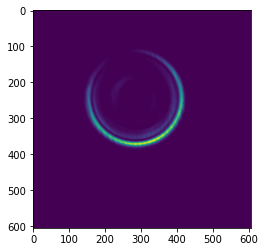

con_todo


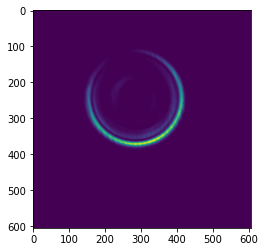

sin_negativo


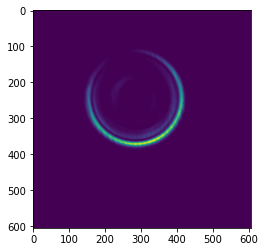

sin_positivo


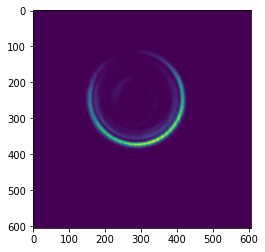

90


In [19]:
%%skip $dont_use_experimental
# General pipeline settings
output_path = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/Pipeline/{pipe_name}/"
#output_path = F"/home/melanie/Desktop/Conical_Refraction_Polarimeter/OUTPUT/Pipeline/{pipe_name}/"
output_units = 'deg'
confidence = 90
boots_samples = 10000

dtype = np.float64
dtype_torch = torch.float64

n_jobs=10

GT_units = 'deg'
GT_nature = 'pol'

if pipe_name=="Proof_of_concept2":
    # Get the Images to Test
    images_path = "../EXPERIMENTAL/Fotos_Turpin/ProofOfConcept/"
    #images_path = "/home/melanie/Desktop/Conical_Refraction_Polarimeter/LAB/EXPERIMENTAL/TEST_IMAGES/"
    exp_names=[f'MetaBlock_{current_meta_block}_Block_{current_block}_Sub_block_{current_sub_block}']
    names = ['ezer', 'bixek', 'sin_negat', 'sin_posit']
    GT_abs = [ 0,  5.11, 16.10, -10.98]
    repetitions = list(range(3))
    h=540
    w=720

    image_pair_names = []
    indices = [(0,1),(0,2), (0,3), (1,2), (1,3), (2,3)]

    show=[0,1,2,3]


    references = np.zeros((len(indices), 2*X+1, 2*X+1), dtype=dtype)
    problems = np.zeros((len(indices), 2*X+1, 2*X+1), dtype=dtype)
    ground_truths = np.zeros(len(indices), dtype=np.float64)

    for k, (ref, pb) in enumerate(indices):
        image_pair_names.append(f"REF_{names[ref]}_PB_{names[pb]}")

        imgR = np.zeros((h, w), dtype=np.float64)
        imgP = np.zeros((h, w), dtype=np.float64)
        for j in repetitions:
            j+=1
            imgR += cv2.imread(f"{images_path}/{names[ref]}{j}.png", cv2.IMREAD_GRAYSCALE).astype(np.float64)
            imgP += cv2.imread(f"{images_path}/{names[pb]}{j}.png", cv2.IMREAD_GRAYSCALE).astype(np.float64)
        # iX center
        references[k] = compute_raw_to_centered_iX(imgR/len(repetitions), X)
        problems[k] = compute_raw_to_centered_iX(imgP/len(repetitions), X)
        if pb in show:
            plt.imshow(references[k])
            plt.show()
            print(names[pb])
            show.remove(pb)

        ground_truths[k] = GT_abs[ref]-GT_abs[pb]
        
elif pipe_name=="HeNe2":
    # Get the Images to Test
    images_path = "../EXPERIMENTAL/Fotos_Turpin/New_Day/Experimento_Referencia_HeNe/"
    #images_path = "/home/melanie/Desktop/Conical_Refraction_Polarimeter/LAB/EXPERIMENTAL/TEST_IMAGES/"
    exp_names=[f'MetaBlock_{current_meta_block}_Block_{current_block}_Sub_block_{current_sub_block}']
    names = ['sin_nada', 'con_todo', 'sin_negativo', 'sin_positivo']
    #GT_abs = [ 0,  5.11, 16.10, -10.98]
    GT_abs = [0, 4.40, 13.85, -9.45]
    repetitions = list(range(20))
    h=540
    w=720

    image_pair_names = []
    indices = [(0,1),(0,2), (0,3), (1,2), (1,3), (2,3)]

    show=[0,1,2,3]


    references = np.zeros((len(indices)+1, 2*X+1, 2*X+1), dtype=dtype)
    problems = np.zeros((len(indices)+1, 2*X+1, 2*X+1), dtype=dtype)
    ground_truths = np.zeros(len(indices)+1, dtype=np.float64)

    for k, (ref, pb) in enumerate(indices):
        image_pair_names.append(f"REF_{names[ref]}_PB_{names[pb]}")

        imgR = np.zeros((h, w), dtype=np.float64)
        imgP = np.zeros((h, w), dtype=np.float64)
        for j in repetitions:
            imgR += cv2.imread(f"{images_path}/{names[ref]}_{j}.png", cv2.IMREAD_GRAYSCALE).astype(np.float64)
            imgP += cv2.imread(f"{images_path}/{names[pb]}_{j}.png", cv2.IMREAD_GRAYSCALE).astype(np.float64)
        # iX center
        references[k] = compute_raw_to_centered_iX(imgR/len(repetitions), X)
        problems[k] = compute_raw_to_centered_iX(imgP/len(repetitions), X)
        if pb in show:
            plt.imshow(references[k])
            plt.show()
            print(names[pb])
            show.remove(pb)

        ground_truths[k] = GT_abs[ref]-GT_abs[pb]
        
    # Get the Images to Test
    images_path = "../EXPERIMENTAL/Fotos_Turpin/New_Day/Experimento_Ortogonal_HeNe/"
    #images_path = "/home/melanie/Desktop/Conical_Refraction_Polarimeter/LAB/EXPERIMENTAL/TEST_IMAGES/"
    exp_names=[f'MetaBlock_{current_meta_block}_Block_{current_block}_Sub_block_{current_sub_block}']
    names = ['0_2', '90']
    GT_abs = [0, 90]
    repetitions = list(range(20))
    h=540
    w=720

    indices = [(0,1)]

    show=[0,1]


    for k, (ref, pb) in enumerate(indices):
        image_pair_names.append(f"REF_{names[ref]}_PB_{names[pb]}")

        imgR = np.zeros((h, w), dtype=np.float64)
        imgP = np.zeros((h, w), dtype=np.float64)
        for j in repetitions:
            imgR += cv2.imread(f"{images_path}/{names[ref]}_{j}.png", cv2.IMREAD_GRAYSCALE).astype(np.float64)
            imgP += cv2.imread(f"{images_path}/{names[pb]}_{j}.png", cv2.IMREAD_GRAYSCALE).astype(np.float64)
        # iX center
        references[-1] = compute_raw_to_centered_iX(imgR/len(repetitions), X)
        problems[-1] = compute_raw_to_centered_iX(imgP/len(repetitions), X)
        if pb in show:
            plt.imshow(references[-1])
            plt.show()
            print(names[pb])
            show.remove(pb)

        ground_truths[-1] = GT_abs[ref]-GT_abs[pb]

In [ ]:
%%skip $dont_use_experimental

table_per_alg={}
table_per_image={}
exp_names=[f'MetaBlock_{current_meta_block}_Block_{current_block}_Sub_block_{current_sub_block}']# , 'Normalize_to_average', 'Sigmoid de parametros tal y cual']


algorithm_lambda_list=[]
algorithm_name_list = []

from skimage import morphology

def get_gravicentrum_batched(images, batch_size=200):
    gravicenters = np.zeros((images.shape[0], 2), dtype=np.float64)
    for j in range(0, images.shape[0], batch_size):
        gravicenters[j:(j+batch_size)] = compute_intensity_gravity_centers_torch(
            torch.from_numpy(images[j:(j+batch_size)]).to(device)).to('cpu').numpy()
        free()
    return gravicenters

emb_dims=10
random_seed=666

if current_block==1: # Experimental Embedder+KNN Regressor
    
    def normalize_to_max_and_iX_input_output_flatten_knn(images, dtype=np.float64,
                    iX_dev='cpu', out_dev='cpu', X=X, batch_size=100): # images expected to be [N_images, h, w]
        out = np.zeros((images.shape[0], (2*X+1)**2), dtype=np.float64)
        images= images.reshape(-1, X*2+1, X*2+1).astype(dtype)/np.expand_dims( np.amax(images, axis=(-2,-1) ), (-2,-1) )
        for j in range(0, images.shape[0], batch_size):
            out[j:(j+batch_size)] = compute_raws_to_centered_iXs_torch( torch.from_numpy(images[j:(j+batch_size)]).to(device), X, device).to('cpu').numpy().reshape(len(out[j:(j+batch_size)]), -1)
            torch.cuda.empty_cache()
            gc.collect()
        return out
    
    if current_sub_block<9: # embedder knns trained with noisy dataset
        embedder_exp_name="Noisy_Dataset_Embedders"
        emb_knn_path = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/Embedders/Embedders_and_KNN/{embedder_exp_name}/"
    elif current_sub_block>8:
        embedder_exp_name="Non_Noisy_Dataset_Embedders"
        emb_knn_path = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/Embedders/Embedders_and_KNN/{embedder_exp_name}/"
        

    if current_sub_block==1 or current_sub_block==9:
        # PCA -> Existe la incremental PCA por si es massa grande el dataset!
        args = {'exp':'PCA','emb_dims':emb_dims, "whiten":True}
        embedder = sk.decomposition.PCA(n_components=args['emb_dims'], whiten=args['whiten'], random_state=random_seed)
        
        if current_sub_block==1: # noisy trained
            f_name_emb = "PCA_EMBEDDER_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_04_07_2022_12h21m1656930066.sav"
            f_name_knn = "PCA_KNN_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_04_07_2022_12h21m1656930066.sav"
        elif current_sub_block==9: # non-noisy trained
            f_name_emb = "PCA_EMBEDDER_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_05_07_2022_23h10m1657055407.sav"
            f_name_knn = "PCA_KNN_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_05_07_2022_23h10m1657055407.sav"

    elif current_sub_block==2 or current_sub_block==10:
        # KPCA
        args = {'exp':'KPCA_rbf', 'emb_dims':emb_dims, 'kernel':'rbf', 'fit_inverse':True, 'max_iter':100}
        # kernels: linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘cosine’, ‘precomputed’
        embedder = sk.decomposition.KernelPCA(n_components=args['emb_dims'], kernel=args['kernel'], 
                        fit_inverse_transform=args['fit_inverse'], max_iter=args['max_iter'], 
                                random_state=random_seed, n_jobs=n_jobs)
        if current_sub_block==2: # noisy trained
            f_name_emb = "KPCA_rbf_EMBEDDER_n_images_3000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_15_07_2022_19h47m1657907266.sav"
            f_name_knn = "KPCA_rbf_KNN_n_images_3000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_15_07_2022_19h47m1657907266.sav"
        elif current_sub_block==10: # non-noisy trained
            f_name_emb = "KPCA_rbf_EMBEDDER_n_images_3000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_15_07_2022_14h39m1657888747.sav"
            f_name_knn = "KPCA_rbf_KNN_n_images_3000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_15_07_2022_14h39m1657888747.sav"
           
    elif current_sub_block==3 or current_sub_block==11:
        # LLE 
        args = {'exp':'LLE_standard',"method":"standard", "n_neighbors": 200, "emb_dims": emb_dims, 'max_iter':100}
        # Methods: standard, hessian, ltsa, modified (modified_tol) 
        embedder = sk.manifold.LocallyLinearEmbedding(method=args['method'], n_neighbors=args['n_neighbors'],
                      n_components=args['emb_dims'], max_iter=args['max_iter'], random_state=random_seed, n_jobs=n_jobs)
        if current_sub_block==3: # noisy trained
            f_name_emb = "LLE_standard_EMBEDDER_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_05_07_2022_20h00m1657044055.sav"
            f_name_knn = "LLE_standard_KNN_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_05_07_2022_20h00m1657044055.sav"
        elif current_sub_block==11: # non-noisy trained
            f_name_emb = "LLE_standard_EMBEDDER_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_06_07_2022_12h23m1657102984.sav"
            f_name_knn = "LLE_standard_KNN_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_06_07_2022_12h23m1657102984.sav"
        
        
    elif current_sub_block==4 or current_sub_block==12:
        # ISOMAP
        args = {'exp':'ISOMAP', 'n_neighbors':200, 'emb_dims':emb_dims, 'max_iter':100, 'neighbors_algorithm':'auto', 'metric':'minkowski' }
        embedder = sk.manifold.Isomap( n_neighbors=args['n_neighbors'],n_components=args['emb_dims'],
                            max_iter=args['max_iter'], neighbors_algorithm=args['neighbors_algorithm'], n_jobs=n_jobs,
                            metric=args['metric'], p=2)
        if current_sub_block==4: # noisy trained
            f_name_emb = "ISOMAP_EMBEDDER_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_04_07_2022_12h24m1656930242.sav"
            f_name_knn = "ISOMAP_KNN_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_04_07_2022_12h24m1656930242.sav"
        elif current_sub_block==12: # non-noisy trained
            f_name_emb = "ISOMAP_EMBEDDER_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_06_07_2022_14h08m1657109335.sav"
            f_name_knn = "ISOMAP_KNN_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_06_07_2022_14h08m1657109335.sav"
        
    elif current_sub_block==5 or current_sub_block==13:
        # UMAP -> uses y continous
        args = {'exp':'UMAP', 'emb_dims':emb_dims, 'min_dist':0.1, 'n_neighbors':300, 'metric':'hamming', 'n_epochs':None,
               'target_metric':'l2'}
        # Metrics: euclidean, canberra, cosine, manhattan, braycurtis, mahalanobis, hamming
        embedder = umap.UMAP(n_components=args['emb_dims'], min_dist=args['min_dist'], n_epochs=args['n_epochs'],
                    n_neighbors=args['n_neighbors'], metric=args['metric'], random_state=random_seed, n_jobs=n_jobs,
                            target_metric=args['target_metric']) 
        if current_sub_block==5: # noisy trained
            f_name_emb = "UMAP_EMBEDDER_n_images_4000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_14_07_2022_22h33m1657830789.sav"
            f_name_knn = "UMAP_KNN_n_images_4000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_14_07_2022_22h33m1657830789.sav"
        elif current_sub_block==13: # non-noisy trained
            f_name_emb = "UMAP_EMBEDDER_n_images_4000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_15_07_2022_04h21m1657851668.sav"
            f_name_knn = "UMAP_KNN_n_images_4000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_15_07_2022_04h21m1657851668.sav"
        
        
    elif current_sub_block==6 or current_sub_block==14:
        # NCA -> uses y categorical Ezin 5000
        args = {'exp':'NCA', 'emb_dims':emb_dims, 'init':'auto', 'max_iter':100 }
        # init ‘auto’, ‘pca’, ‘lda’, ‘identity’, ‘random’
        embedder = sk.neighbors.NeighborhoodComponentsAnalysis(n_components=args['emb_dims'], init=args['init'],
                                        max_iter=args['max_iter'], random_state=random_seed)
        if current_sub_block==6: # noisy trained
            f_name_emb = "NCA_EMBEDDER_n_images_2000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_07_07_2022_23h17m1657228679.sav"
            f_name_knn = "NCA_KNN_n_images_2000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_07_07_2022_23h17m1657228679.sav"
        elif current_sub_block==14: # non-noisy trained
            f_name_emb = "NCA_EMBEDDER_n_images_2000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_07_07_2022_14h43m1657197822.sav"
            f_name_knn = "NCA_KNN_n_images_2000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_07_07_2022_14h43m1657197822.sav"
        

    elif current_sub_block==7 or current_sub_block==15:
        args = {'exp':'RAW'}
        embedder = lambda X : X
        if current_sub_block==7: # noisy trained
            f_name_emb = "RAW_EMBEDDER_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_05_07_2022_19h58m1657043897.sav"
            f_name_knn = "RAW_KNN_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_05_07_2022_19h58m1657043897.sav"
        elif current_sub_block==15: # non-noisy trained
            f_name_emb = "RAW_EMBEDDER_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_06_07_2022_12h20m1657102825.sav"
            f_name_knn = "RAW_KNN_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_06_07_2022_12h20m1657102825.sav"
        

    
    text = "noisy" if current_sub_block<9 else "non_noisy"
    if current_sub_block<8 or (current_sub_block>8 and current_sub_block<16): # scikit learn embedders
        #preprocess_and_embed = dill.load((open(emb_knn_path+f_name_emb, 'rb')))
        trained_knn_alg = dill.load((open(emb_knn_path+f_name_knn, 'rb')))
        trained_knn_alg.embedder_func.preprocess_fct = normalize_to_max_and_iX_input_output_flatten_knn
        if args['exp']=='RAW':
            trained_knn_alg.embedder_func.embedder.transform=trained_knn_alg.embedder_func.embedder
            
        algorithm_lambda_list.append(
                lambda refs, pbs, image_pair_names, dir_alg : run_knn_on_embedding_space(refs, pbs,
                                                                    image_pair_names, trained_knn_alg)
            )
        algorithm_name_list.append(
                f"Embedder_KNN_{args['exp']}_Trained_w{text}_DS_Exper"
            )
    
    if current_sub_block==8 or current_sub_block==16:
        args_NN_encoder = {'X':302, 'feats_1':20, 'feats_2':20, 'feats_3':20, 'feats_4':5, 'prop1':2.5, 'prop2':1.5,
                  'prop3':0.6, 'av_pool1_div':2, 'conv4_feat_size':8, 'av_pool2_div':10, 'out_fc_1':5,
                  'dropout_p1':0.2, 'dropout_p2':0.1, 'out_fc2':10} # out_fc_2 is the output dim of the embedding space
        args_NN_denoiser = {'X':302, 'S0':2*302+1, 'S1':2*250+1, 'S2':2*200+1, 'S3':2*150+1, 'S4':2*10+1,
                            'S5':2*1+1, 'S6':2, 'feats_S1':5, 'feats_S2':5, 'feats_S3':10, 'feats_S4':20,
                            'feats_S5':20, 'feats_S6':25, 'out_fc1':100, 'dropout_p':0.1, 'out_fc_2':10}

        saved_NN_path=f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Proximity_Metric/"

        check_file="BEEEST1_BEST_Model_and_Optimizer_2022-05-03 17:24:03.205978_Proximity_Metric_from_Simple_Encoder_Batch_Hard_Soft_Margin.pt"
        checkpoint = torch.load(saved_NN_path+f"/NNs/{check_file}")
        triplet_embedder = Triplet_NN_embedder( args_NN_encoder, 
                checkpoint_path=saved_NN_path+'/NNs/'+check_file, 
                device=device, encoder_or_denoiser_based="encoder", output_to="numpy")
        
        if current_sub_block==8:
            f_path_knn="Triplet_CNN_KNN_n_images_5000_emb_dims_10_seed_666_date_08_07_2022_10h31m45s.sav"
        elif current_sub_block==16:
            f_path_knn="Triplet_CNN_KNN_n_images_5000_emb_dims_10_seed_666_date_07_07_2022_16h49m21s.sav"
        
        trained_knn_alg = dill.load((open(emb_knn_path+f_path_knn, 'rb')))
        trained_knn_alg.embedder_func = triplet_embedder
        trained_knn_alg.embedder_func.preprocess_fct = normalize_to_max_and_iX_input_output_flatten_knn

        algorithm_lambda_list.append(
                lambda refs, pbs, image_pair_names, dir_alg : run_knn_on_embedding_space(refs, pbs,
                                                                    image_pair_names, trained_knn_alg)
            )
        algorithm_name_list.append(
                f"Embedder_Triplet_CNN_KNN_Trained_w{text}_DS_Exper"
            )
        free()
     
    
elif current_block==2 or current_block==3: # Simulation Gravicenter or Geometric center
    ID_file_path=  "/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_115x_w0_115x_Z_3x_64bit/STRUCTURE_Grid_R0_115_w0_115_Z_3.json"
    D_matrix_file_path= "/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_115x_w0_115x_Z_3x_64bit/SIMULATIONS/Dataset_R0_115_w0_115_Z_3.h5"

    #ID_file_path=  "/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/STRUCTURE_Grid_R0_70_w0_70_Z_4.json"
    #D_matrix_file_path= "/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Dataset_R0_70_w0_70_Z_4.h5"

    #ID_file_path=  "/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_Proof_of_Concept/STRUCTURE_Grid_R0_115_w0_115_Z_1.json"
    #D_matrix_file_path= "/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_Proof_of_Concept/SIMULATIONS/Dataset_R0_115_w0_115_Z_1.h5"

    simulation_fit_kw_args_NM = {'ID_file_path':ID_file_path , 'D_matrix_file_path':D_matrix_file_path, 'device':device,
                             'similarity_alg':lambda im1, im2: torch.sum(torch.abs(im1-im2)).item(),
                            'use_exact_gravicenter':True, 'X':X,
            'gravicenter_alg': lambda ims: compute_intensity_gravity_centers_torch( ims ).to('cpu').numpy(),
                              'method':'Nelder-Mead',
                             'max_it':70, 'max_evals':100, 'abs_tol':0, 'rel_tol':0,
                             'max_it_Blaz':40, 'max_evals_Blaz':40, 'abs_tol_Blaz':0, 'rel_tol_Blaz':0}

    simulation_fit_kw_args_P = {'ID_file_path':ID_file_path , 'D_matrix_file_path':D_matrix_file_path, 'device':device,
                             'similarity_alg':lambda im1, im2: torch.sum(torch.abs(im1-im2)).item(),
                            'use_exact_gravicenter':True, 'X':X,
            'gravicenter_alg': lambda ims: compute_intensity_gravity_centers_torch( ims ).to('cpu').numpy(),
                              'method':'Powell',
                             'max_it':70, 'max_evals':100, 'abs_tol':0, 'rel_tol':0,
                             'max_it_Blaz':40, 'max_evals_Blaz':40, 'abs_tol_Blaz':0, 'rel_tol_Blaz':0}
    
    #text_DS = "Noisy" if current_block==2 else "Non_Noisy"
    geomgrav = "Grav" if current_block==2 else "Geom"
    run_alg = run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR if current_block==2 else run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR_geometric_center
    if current_sub_block==1: # to max
        # to max noisy and iX
        if current_block==2:
            def simulation_preprocess_fct(images, in_are_dev_float, dtype=torch.float64):
                if not in_are_dev_float:
                    images = images.type(dtype).to(device)
                    free()
                return compute_raws_to_centered_iXs_torch(
                            images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)),
                                  X=X, device=device)
        
        
            algorithm_lambda_list+=[
                lambda refs, pbs, image_pair_names, dir_alg : run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR(
                                                refs, pbs, image_pair_names, 
                                                simulation_preprocess_fct, simulation_fit_kw_args_NM, embedder=None),
                lambda refs, pbs, image_pair_names, dir_alg : run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR(
                                                refs, pbs, image_pair_names, 
                                                simulation_preprocess_fct, simulation_fit_kw_args_P, embedder=None),
                ]
        else:
            def pregeom_preprocess_fct(images, in_are_dev_float, dtype=torch.float64):
                if not in_are_dev_float:
                    images = images.type(dtype).to(device)
                    free()
                return images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1))
            
            def postgeom_preprocess_fct(images, in_are_dev_float, dtype=torch.float64):
                if not in_are_dev_float:
                    images = images.type(dtype).to(device)
                    free()
                return images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1))
        
        
            algorithm_lambda_list+=[
                lambda refs, pbs, image_pair_names, dir_alg : run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR_geometric_center(
                                                refs, pbs, image_pair_names, 
                                                pregeom_preprocess_fct, postgeom_preprocess_fct, simulation_fit_kw_args_NM, embedder=None),
                lambda refs, pbs, image_pair_names, dir_alg : run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR_geometric_center(
                                                refs, pbs, image_pair_names, 
                                                pregeom_preprocess_fct, postgeom_preprocess_fct, simulation_fit_kw_args_P, embedder=None),
            ]
        if current_meta_block<3:
            algorithm_name_list+=[
                f"Simulation_{geomgrav}_Prepr_Max_DS_Exper_Searc_NM",
                f"Simulation_{geomgrav}_Prepr_Max_DS_Exper_Searc_P",
            ]
        elif current_meta_block==3:
            algorithm_name_list+=[
                f"Simulation_{geomgrav}_Prepr_Max_DS_Non_Noisy_Searc_NM",
                f"Simulation_{geomgrav}_Prepr_Max_DS_Non_Noisy_Searc_P",
            ]
        
          
    elif current_sub_block==2: # to mean
        # to max then to mean noisy and iX
                               
        if current_block==2:
            def simulation_preprocess_fct(images, in_are_dev_float, dtype=torch.float64):
                if not in_are_dev_float:
                    images = images.type(dtype).to(device)
                    free()
                images = images/torch.mean(images, axis=(-1,-2), keepdims=True)
                return compute_raws_to_centered_iXs_torch(
                    images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)),
                         X=X, device=device)
        
        
            algorithm_lambda_list+=[
                lambda refs, pbs, image_pair_names, dir_alg : run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR(
                                                refs, pbs, image_pair_names, 
                                                simulation_preprocess_fct, simulation_fit_kw_args_NM, embedder=None),
                lambda refs, pbs, image_pair_names, dir_alg : run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR(
                                                refs, pbs, image_pair_names, 
                                                simulation_preprocess_fct, simulation_fit_kw_args_P, embedder=None),
            ]
        else:
            def pregeom_preprocess_fct(images, in_are_dev_float, dtype=torch.float64):
                if not in_are_dev_float:
                    images = images.type(dtype).to(device)
                    free()
                return images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1))
            
            def postgeom_preprocess_fct(images, in_are_dev_float, dtype=torch.float64):
                if not in_are_dev_float:
                    images = images.type(dtype).to(device)
                    free()
                images = images/torch.mean(images, axis=(-1,-2), keepdims=True)
                return images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1))
        
        
            algorithm_lambda_list+=[
                lambda refs, pbs, image_pair_names, dir_alg : run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR_geometric_center(
                                                refs, pbs, image_pair_names, 
                                                pregeom_preprocess_fct, postgeom_preprocess_fct, simulation_fit_kw_args_NM, embedder=None),
                lambda refs, pbs, image_pair_names, dir_alg : run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR_geometric_center(
                                                refs, pbs, image_pair_names, 
                                                pregeom_preprocess_fct, postgeom_preprocess_fct, simulation_fit_kw_args_P, embedder=None),
            ]
        algorithm_name_list+=[
                f"Simulation_{geomgrav}_Prepr_Mean_DS_Exper_Searc_NM",
                f"Simulation_{geomgrav}_Prepr_Mean_DS_Exper_Searc_P",
        ]
        free()

    elif current_sub_block==3: # sigmoid luts
        
        if current_block==2:
            def preprocess_fct(images, in_are_dev_float, center,
                    slope_squeezeness, dtype=torch.float64):
                if not in_are_dev_float:
                    images = images.type(dtype).to(device)
                    free()
                images = images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1))   # normalize
                return compute_raws_to_centered_iXs_torch(
                            1.0/(1+torch.exp(-slope_squeezeness*(images-center)))
                                                          , X, device)
        
            algorithm_lambda_list+=[
                lambda refs, pbs, image_pair_names, dir_alg : run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR(
                                                refs, pbs, image_pair_names, 
                    preprocess_fct=lambda images, in_are_dev_float: preprocess_fct(images, in_are_dev_float,
                                                                                center=0.1, slope_squeezeness=35), 
                    simulation_fit_kw_args=simulation_fit_kw_args_NM, embedder=None),
                lambda refs, pbs, image_pair_names, dir_alg : run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR(
                                                refs, pbs, image_pair_names, 
                    preprocess_fct=lambda images, in_are_dev_float: preprocess_fct(images, in_are_dev_float,
                                                                                center=0.1, slope_squeezeness=35),
                    simulation_fit_kw_args=simulation_fit_kw_args_P, embedder=None),
            ]
        else:
            def pregeom_preprocess_fct(images, in_are_dev_float, dtype=torch.float64):
                if not in_are_dev_float:
                    images = images.type(dtype).to(device)
                    free()
                return images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1))
            
            def postgeom_preprocess_fct(images, in_are_dev_float, center=0.1,
                    slope_squeezeness=35, dtype=torch.float64):
                if not in_are_dev_float:
                    images = images.type(dtype).to(device)
                    free()
                images = images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1))   # normalize
                return 1.0/(1+torch.exp(-slope_squeezeness*(images-center)))
        
        
            algorithm_lambda_list+=[
                lambda refs, pbs, image_pair_names, dir_alg : run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR_geometric_center(
                                                refs, pbs, image_pair_names, 
                                                pregeom_preprocess_fct, postgeom_preprocess_fct, simulation_fit_kw_args_NM, embedder=None),
                lambda refs, pbs, image_pair_names, dir_alg : run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR_geometric_center(
                                                refs, pbs, image_pair_names, 
                                                pregeom_preprocess_fct, postgeom_preprocess_fct, simulation_fit_kw_args_P, embedder=None),
            ]
        algorithm_name_list+=[
                f"Simulation_{geomgrav}_Prepr_Sigm_cent_{0.1}_slp_{35}_DS_Exper_Searc_NM",
                f"Simulation_{geomgrav}_Prepr_Sigm_cent_{0.1}_slp_{35}_DS_Exper_Searc_P",
        ]
        free()
        
    if current_sub_block>3:
        # to max noisy and iX
        def simulation_preprocess_fct(images, in_are_dev_float, dtype=torch.float64):
            if not in_are_dev_float:
                images = images.type(dtype).to(device)
                free()
            return compute_raws_to_centered_iXs_torch(
                        images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)),
                              X=X, device=device)
        
    if current_sub_block==4: # Triplet embedder
        saved_NN_path=f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Proximity_Metric/"
        check_file="BEEEST1_BEST_Model_and_Optimizer_2022-05-03 17:24:03.205978_Proximity_Metric_from_Simple_Encoder_Batch_Hard_Soft_Margin.pt"

        checkpoint_path=saved_NN_path+f"/NNs/{check_file}"


        args_NN_encoder = {'X':302, 'feats_1':20, 'feats_2':20, 'feats_3':20, 'feats_4':5, 'prop1':2.5, 'prop2':1.5,
                          'prop3':0.6, 'av_pool1_div':2, 'conv4_feat_size':8, 'av_pool2_div':10, 'out_fc_1':5,
                          'dropout_p1':0.2, 'dropout_p2':0.1, 'out_fc2':10} # out_fc_2 is the output dim of the embedding space

        triplet_embedder_simulator = Proximity_Metric_Based_On_Simple_Encoder( X=args_NN_encoder['X'], 
                        feats_1=args_NN_encoder['feats_1'], feats_2=args_NN_encoder['feats_2'], 
                        feats_3=args_NN_encoder['feats_3'], feats_4=args_NN_encoder['feats_4'],
                         prop1=args_NN_encoder['prop1'], prop2=args_NN_encoder['prop2'], prop3=args_NN_encoder['prop3'], 
                        av_pool1_div=args_NN_encoder['av_pool1_div'], conv4_feat_size=args_NN_encoder['conv4_feat_size'], 
                        av_pool2_div=args_NN_encoder['av_pool2_div'], 
                         out_fc_1=args_NN_encoder['out_fc_1'], out_fc_2=args_NN_encoder['out_fc2'],
                         dropout_p1=args_NN_encoder['dropout_p1'], dropout_p2=args_NN_encoder['dropout_p2'] )
        triplet_embedder_simulator.to(device)
        checkpoint = torch.load(checkpoint_path)
        triplet_embedder_simulator.load_state_dict(checkpoint['model'])
        triplet_embedder_simulator.eval()
        

        algorithm_lambda_list+=[
            lambda refs, pbs, image_pair_names, dir_alg : run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR(
                                        refs, pbs, image_pair_names, 
                        simulation_preprocess_fct, simulation_fit_kw_args_NM, embedder=triplet_embedder_simulator),
        
            lambda refs, pbs, image_pair_names, dir_alg :run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR(refs, pbs, image_pair_names, 
                                     simulation_preprocess_fct, simulation_fit_kw_args_P, embedder=triplet_embedder_simulator)
       
        ]
        algorithm_name_list+=[
                f"Simulation_Grav_Prepr_Triplet_DS_Exper_Searc_NM",
                f"Simulation_Grav_Prepr_Triplet_DS_Exper_Searc_P",
        ]
        free()
        
    if current_sub_block<8: # embedder knns trained with noisy dataset
        embedder_exp_name="Noisy_Dataset_Embedders"
        emb_knn_path = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/Embedders/Embedders_and_KNN/{embedder_exp_name}/"
        text_sk = "noisy"
        
    elif current_sub_block>7:
        embedder_exp_name="Non_Noisy_Dataset_Embedders"
        emb_knn_path = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/Embedders/Embedders_and_KNN/{embedder_exp_name}/"
        text_sk = "non_noisy"
       
    if current_sub_block==5 or current_sub_block==8: # NCA embedder
        # NCA -> uses y categorical Ezin 5000
        args = {'exp':'NCA', 'emb_dims':emb_dims, 'init':'auto', 'max_iter':100 }
        # init ‘auto’, ‘pca’, ‘lda’, ‘identity’, ‘random’
        embedder = sk.neighbors.NeighborhoodComponentsAnalysis(n_components=args['emb_dims'], init=args['init'],
                                        max_iter=args['max_iter'], random_state=random_seed)
        if current_sub_block==5: # noisy trained
            f_name_emb = "NCA_EMBEDDER_n_images_2000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_07_07_2022_23h17m1657228679.sav"
            f_name_knn = "NCA_KNN_n_images_2000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_07_07_2022_23h17m1657228679.sav"
        elif current_sub_block==8: # non-noisy trained
            f_name_emb = "NCA_EMBEDDER_n_images_2000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_07_07_2022_14h43m1657197822.sav"
            f_name_knn = "NCA_KNN_n_images_2000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_07_07_2022_14h43m1657197822.sav"
        
        
    elif current_sub_block==6 or current_sub_block==9: # UMAP embedder
        # UMAP -> uses y continous
        args = {'exp':'UMAP', 'emb_dims':emb_dims, 'min_dist':0.1, 'n_neighbors':300, 'metric':'hamming', 'n_epochs':None,
               'target_metric':'l2'}
        # Metrics: euclidean, canberra, cosine, manhattan, braycurtis, mahalanobis, hamming
        embedder = umap.UMAP(n_components=args['emb_dims'], min_dist=args['min_dist'], n_epochs=args['n_epochs'],
                    n_neighbors=args['n_neighbors'], metric=args['metric'], random_state=random_seed, n_jobs=n_jobs,
                            target_metric=args['target_metric']) 
        if current_sub_block==6: # noisy trained
            f_name_emb = "UMAP_EMBEDDER_n_images_4000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_14_07_2022_22h33m1657830789.sav"
            f_name_knn = "UMAP_KNN_n_images_4000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_14_07_2022_22h33m1657830789.sav"
        elif current_sub_block==9: # non-noisy trained
            f_name_emb = "UMAP_EMBEDDER_n_images_4000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_15_07_2022_04h21m1657851668.sav"
            f_name_knn = "UMAP_KNN_n_images_4000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_15_07_2022_04h21m1657851668.sav"
                
    elif current_sub_block==7 or current_sub_block==10: # ISOMAP embedder
        # ISOMAP
        args = {'exp':'ISOMAP', 'n_neighbors':200, 'emb_dims':emb_dims, 'max_iter':100, 'neighbors_algorithm':'auto', 'metric':'minkowski' }
        embedder = sk.manifold.Isomap( n_neighbors=args['n_neighbors'],n_components=args['emb_dims'],
                            max_iter=args['max_iter'], neighbors_algorithm=args['neighbors_algorithm'], n_jobs=n_jobs,
                            metric=args['metric'], p=2)
        if current_sub_block==7: # noisy trained
            f_name_emb = "ISOMAP_EMBEDDER_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_04_07_2022_12h24m1656930242.sav"
            f_name_knn = "ISOMAP_KNN_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_04_07_2022_12h24m1656930242.sav"
        elif current_sub_block==10: # non-noisy trained
            f_name_emb = "ISOMAP_EMBEDDER_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_06_07_2022_14h08m1657109335.sav"
            f_name_knn = "ISOMAP_KNN_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_06_07_2022_14h08m1657109335.sav"
    
    if current_sub_block>4:
        preprocess_and_embed = dill.load((open(emb_knn_path+f_name_emb, 'rb')))
        
        algorithm_lambda_list+=[
            lambda refs, pbs, image_pair_names, dir_alg : run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR(
                                        refs, pbs, image_pair_names, 
                        simulation_preprocess_fct, simulation_fit_kw_args_NM, 
                embedder = lambda x: torch.from_numpy(preprocess_and_embed.transform(x.to('cpu').numpy().reshape(x.shape[0],-1))).to(device) ),
        
            lambda refs, pbs, image_pair_names, dir_alg :run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR(refs, pbs, image_pair_names, 
                                     simulation_preprocess_fct, simulation_fit_kw_args_P, 
                embedder = lambda x: torch.from_numpy(preprocess_and_embed.transform(x.to('cpu').numpy().reshape(x.shape[0],-1))).to(device) )
       
        ]
        algorithm_name_list+=[
                f"Simulation_Grav_Prepr_{args['exp']}_Trained_w{text_sk}_DS_Exper_Searc_NM",
                f"Simulation_Grav_Prepr_{args['exp']}_Trained_w{text_sk}_DS_Exper_Searc_P",
        ]
        free()
        
else:
    raise ValueError
   
   

print(algorithm_name_list)

# List the Algorithms to test
for exp_name in exp_names:
    table_per_image[exp_name], table_per_alg[exp_name] = run_benchmark_output_result_histograms_and_result_table( \
            algorithm_lambda_list=algorithm_lambda_list, algorithm_name_list=algorithm_name_list,\
            references=references, problems=problems, image_pair_names=image_pair_names,\
            generate_algorithm_plots=False,\
            generate_histograms=False, boots_samples=boots_samples, confidence=confidence,\
            output_units=output_units, ground_truths=ground_truths, GT_units=GT_units,\
            GT_nature = GT_nature,\
            experiment_name = exp_name, \
            output_path=output_path)
    free()
    
# Benetan gordeta dauzelez df danak, al da exekuteu hau bukaeran tras hacerle un input a todos los df-s
# Generate Excel files!
# Excel for algorithms
writer = StyleFrame.ExcelWriter(f'{output_path}/{exp_names[0]}/EXCEL_Results_per_Algorithm.xlsx')
for exp_name in exp_names:
    StyleFrame(pd.DataFrame({'Absolute Error':['Absolute_Error']})).to_excel(writer, sheet_name=exp_name, startcol=1)
    StyleFrame(pd.DataFrame({'Times':['Times']})).to_excel(writer, sheet_name=exp_name, startcol=5)
    sf = StyleFrame(pd.DataFrame(table_per_alg[exp_name].index.get_level_values(0)))
    sf.set_column_width(columns=[1], width=55.0)
    sf.to_excel(writer, sheet_name=exp_name, startrow=1)
    sf = StyleFrame(table_per_alg[exp_name]['Absolute_Error'])
    sf.set_column_width(columns=[ 1,2,3,4], width=15.5)
    sf.to_excel(writer, sheet_name=exp_name, startrow=1, startcol=1, float_format="%.5f")
    sf = StyleFrame(table_per_alg[exp_name]['Times'])
    sf.set_column_width(columns=[ 1,2,3,4], width=15.0)
    sf.to_excel(writer, sheet_name=exp_name,  startrow=1, startcol=5, float_format="%.5f")
writer.save()

free()
# Excel for images
writer = StyleFrame.ExcelWriter(f"{output_path}/{exp_names[0]}/EXCEL_Results_per_Image.xlsx")
StyleFrame.A_FACTOR=10
StyleFrame.P_FACTOR=0.9
for exp_name in exp_names:
    StyleFrame(table_per_image[exp_name]).set_row_height(1,50).to_excel(writer, best_fit=list(table_per_image[exp_name].columns), sheet_name=exp_name, index=False,  float_format="%.8f")
writer.save()



['Simulation_Grav_Prepr_ISOMAP_Trained_wnoisy_DS_Exper_Searc_NM', 'Simulation_Grav_Prepr_ISOMAP_Trained_wnoisy_DS_Exper_Searc_P']
> Passing Images from each Algorithm...


In [ ]:
%%skip $dont_use_experimental
table_per_alg[exp_names[0]] # menos precision en fibo

In [ ]:
%%skip $dont_use_experimental
table_per_image[exp_names[0]][:30]

### (b) Using a large simulated Noisy Image Library

In [ ]:
%%skip $dont_use_simulated
# General pipeline settings
output_path = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/Pipeline/{pipe_name}"
output_units = 'deg'
confidence = 90
boots_samples = 10000
X=X
dtype = np.float64
dtype_torch = torch.float64
n_jobs=10


num_image_pairs_test = 500



if current_meta_block==2:
    use_noisy = True
elif current_meta_block==3:
    use_noisy=False

In [ ]:
%%skip $dont_use_simulated
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import json
import torch
import json

from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader

class ImageDataset(Dataset):
    def __init__(self, GT_file_path, images_dir_path):
        self.df_GTs = pd.DataFrame.from_dict(json.load(open(GT_file_path)))
        self.images_dir_path = images_dir_path
        self.len_data = len(self.df_GTs)

    def __len__(self):
        return self.len_data

    def __getitem__(self, idx):
        img_path = f"{self.images_dir_path}/IM_{self.df_GTs.iloc[idx,0]}_phiCR_{self.df_GTs.iloc[idx,1]}.png"
        image = read_image(img_path) #[1, 2X+1, 2X+1] torch tensor
        label = torch.Tensor([float(self.df_GTs.iloc[idx, 1])]).type(torch.float32) #[1] torch tensor of float32
        return image, label
    
# Noisy Test set!
GT_file_path_test_noisy = f"/home/oiangu/Desktop/Conical_Refraction_Polarimeter/OUTPUT/NOISY/TEST/GROUND_TRUTHS.json"
images_dir_path_test_noisy =f"/home/oiangu/Desktop/Conical_Refraction_Polarimeter/OUTPUT/NOISY/TEST"

# Non-Noisy Test set!
GT_file_path_test_non_noisy = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/IMAGE_LIBRARY/NON_NOISY/TEST/GROUND_TRUTHS.json"
images_dir_path_test_non_noisy = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/IMAGE_LIBRARY/NON_NOISY/TEST"


random_seed = 666

if use_noisy:
    test_data = ImageDataset(GT_file_path_test_noisy, images_dir_path_test_noisy)
else:
    test_data = ImageDataset(GT_file_path_test_non_noisy, images_dir_path_test_non_noisy)

In [ ]:
%%skip $dont_use_simulated
np.random.seed(random_seed)
random_indices_refs = np.random.choice(range(len(test_data)), num_image_pairs_test, replace=False)

X21 = test_data[0][0].shape[1]
X_references = np.zeros( (num_image_pairs_test, X21, X21), dtype=np.float32)
y_references = np.zeros( (num_image_pairs_test), dtype=np.float64)

for j,idx in enumerate(random_indices_refs):
    im, lab = test_data[idx]
    X_references[j, :,:] = im[0]
    y_references[j] = lab

random_indices_pbs = np.random.choice(range(len(test_data)), num_image_pairs_test, replace=False)

X_problems = np.zeros( (num_image_pairs_test, X21, X21), dtype=np.float32)
y_problems = np.zeros( (num_image_pairs_test), dtype=np.float64)

for j,idx in enumerate(random_indices_pbs):
    im, lab = test_data[idx]
    X_problems[j, :,:] = im[0]
    y_problems[j] = lab
    
image_pair_names = [f'REF_{ref_idx}_PB_{pb_idx}' for ref_idx, pb_idx in zip(random_indices_refs, random_indices_pbs)]

ground_truths = y_problems-y_references
ground_truths = np.array([angle_to_pi_pi(phi) for phi in ground_truths])/2

del y_problems
del y_references
free()

GT_units = 'rad'
GT_nature = 'pol'

In [ ]:
%%skip $dont_use_simulated

table_per_alg={}
table_per_image={}
exp_names=[f'MetaBlock_{current_meta_block}_Block_{current_block}_Sub_block_{current_sub_block}']# , 'Normalize_to_average', 'Sigmoid de parametros tal y cual']


algorithm_lambda_list=[]
algorithm_name_list = []

from skimage import morphology

def get_gravicentrum_batched(images, batch_size=200):
    gravicenters = np.zeros((images.shape[0], 2), dtype=np.float64)
    for j in range(0, images.shape[0], batch_size):
        gravicenters[j:(j+batch_size)] = compute_intensity_gravity_centers_torch(
            torch.from_numpy(images[j:(j+batch_size)]).to(device)).to('cpu').numpy()
        free()
    return gravicenters

emb_dims=10


if current_block==1: # Experimental Embedder+KNN Regressor
    def normalize_to_max_and_iX_input_output_flatten_knn(images, dtype=np.float64,
                    iX_dev='cpu', out_dev='cpu', X=X, batch_size=100): # images expected to be [N_images, h, w]
        out = np.zeros((images.shape[0], (2*X+1)**2), dtype=np.float64)
        images= images.reshape(-1, X*2+1, X*2+1).astype(dtype)/np.expand_dims( np.amax(images, axis=(-2,-1) ), (-2,-1) )
        for j in range(0, images.shape[0], batch_size):
            out[j:(j+batch_size)] = compute_raws_to_centered_iXs_torch( torch.from_numpy(images[j:(j+batch_size)]).to(device), X, device).to('cpu').numpy().reshape(len(out[j:(j+batch_size)]), -1)
            torch.cuda.empty_cache()
            gc.collect()
        return out
    
    if current_sub_block<9: # embedder knns trained with noisy dataset
        embedder_exp_name="Noisy_Dataset_Embedders"
        emb_knn_path = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/Embedders/Embedders_and_KNN/{embedder_exp_name}/"
    elif current_sub_block>8:
        embedder_exp_name="Non_Noisy_Dataset_Embedders"
        emb_knn_path = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/Embedders/Embedders_and_KNN/{embedder_exp_name}/"
        

    if current_sub_block==1 or current_sub_block==9:
        # PCA -> Existe la incremental PCA por si es massa grande el dataset!
        args = {'exp':'PCA','emb_dims':emb_dims, "whiten":True}
        embedder = sk.decomposition.PCA(n_components=args['emb_dims'], whiten=args['whiten'], random_state=random_seed)
        
        if current_sub_block==1: # noisy trained
            f_name_emb = "PCA_EMBEDDER_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_04_07_2022_12h21m1656930066.sav"
            f_name_knn = "PCA_KNN_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_04_07_2022_12h21m1656930066.sav"
        elif current_sub_block==9: # non-noisy trained
            f_name_emb = "PCA_EMBEDDER_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_05_07_2022_23h10m1657055407.sav"
            f_name_knn = "PCA_KNN_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_05_07_2022_23h10m1657055407.sav"
    elif current_sub_block==2 or current_sub_block==10:
        # KPCA
        args = {'exp':'KPCA_rbf', 'emb_dims':emb_dims, 'kernel':'rbf', 'fit_inverse':True, 'max_iter':100}
        # kernels: linear’, ‘poly’, ‘rbf’, ‘sigmoid’
        embedder = sk.decomposition.KernelPCA(n_components=args['emb_dims'], kernel=args['kernel'], 
                        fit_inverse_transform=args['fit_inverse'], max_iter=args['max_iter'], 
                                random_state=random_seed, n_jobs=n_jobs)
        if current_sub_block==2: # noisy trained
            f_name_emb = "KPCA_rbf_EMBEDDER_n_images_3000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_15_07_2022_19h47m1657907266.sav"
            f_name_knn = "KPCA_rbf_KNN_n_images_3000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_15_07_2022_19h47m1657907266.sav"
        elif current_sub_block==10: # non-noisy trained
            f_name_emb = "KPCA_rbf_EMBEDDER_n_images_3000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_15_07_2022_14h39m1657888747.sav"
            f_name_knn = "KPCA_rbf_KNN_n_images_3000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_15_07_2022_14h39m1657888747.sav"
            
    elif current_sub_block==3 or current_sub_block==11:
        # LLE 
        args = {'exp':'LLE_standard',"method":"standard", "n_neighbors": 200, "emb_dims": emb_dims, 'max_iter':100}
        # Methods: standard, hessian, ltsa, modified (modified_tol) 
        embedder = sk.manifold.LocallyLinearEmbedding(method=args['method'], n_neighbors=args['n_neighbors'],
                      n_components=args['emb_dims'], max_iter=args['max_iter'], random_state=random_seed, n_jobs=n_jobs)
        if current_sub_block==3: # noisy trained
            f_name_emb = "LLE_standard_EMBEDDER_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_05_07_2022_20h00m1657044055.sav"
            f_name_knn = "LLE_standard_KNN_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_05_07_2022_20h00m1657044055.sav"
        elif current_sub_block==11: # non-noisy trained
            f_name_emb = "LLE_standard_EMBEDDER_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_06_07_2022_12h23m1657102984.sav"
            f_name_knn = "LLE_standard_KNN_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_06_07_2022_12h23m1657102984.sav"
        
        
    elif current_sub_block==4 or current_sub_block==12:
        # ISOMAP
        args = {'exp':'ISOMAP', 'n_neighbors':200, 'emb_dims':emb_dims, 'max_iter':100, 'neighbors_algorithm':'auto', 'metric':'minkowski' }
        embedder = sk.manifold.Isomap( n_neighbors=args['n_neighbors'],n_components=args['emb_dims'],
                            max_iter=args['max_iter'], neighbors_algorithm=args['neighbors_algorithm'], n_jobs=n_jobs,
                            metric=args['metric'], p=2)
        if current_sub_block==4: # noisy trained
            f_name_emb = "ISOMAP_EMBEDDER_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_04_07_2022_12h24m1656930242.sav"
            f_name_knn = "ISOMAP_KNN_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_04_07_2022_12h24m1656930242.sav"
        elif current_sub_block==12: # non-noisy trained
            f_name_emb = "ISOMAP_EMBEDDER_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_06_07_2022_14h08m1657109335.sav"
            f_name_knn = "ISOMAP_KNN_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_06_07_2022_14h08m1657109335.sav"
        
    elif current_sub_block==5 or current_sub_block==13:
        # UMAP -> uses y continous
        args = {'exp':'UMAP', 'emb_dims':emb_dims, 'min_dist':0.1, 'n_neighbors':300, 'metric':'hamming', 'n_epochs':None,
               'target_metric':'l2'}
        # Metrics: euclidean, canberra, cosine, manhattan, braycurtis, mahalanobis, hamming
        embedder = umap.UMAP(n_components=args['emb_dims'], min_dist=args['min_dist'], n_epochs=args['n_epochs'],
                    n_neighbors=args['n_neighbors'], metric=args['metric'], random_state=random_seed, n_jobs=n_jobs,
                            target_metric=args['target_metric']) 
        if current_sub_block==5: # noisy trained
            f_name_emb = "UMAP_EMBEDDER_n_images_4000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_14_07_2022_22h33m1657830789.sav"
            f_name_knn = "UMAP_KNN_n_images_4000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_14_07_2022_22h33m1657830789.sav"
        elif current_sub_block==13: # non-noisy trained
            f_name_emb = "UMAP_EMBEDDER_n_images_4000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_15_07_2022_04h21m1657851668.sav"
            f_name_knn = "UMAP_KNN_n_images_4000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_15_07_2022_04h21m1657851668.sav"
                
        
    elif current_sub_block==6 or current_sub_block==14:
        # NCA -> uses y categorical Ezin 5000
        args = {'exp':'NCA', 'emb_dims':emb_dims, 'init':'auto', 'max_iter':100 }
        # init ‘auto’, ‘pca’, ‘lda’, ‘identity’, ‘random’
        embedder = sk.neighbors.NeighborhoodComponentsAnalysis(n_components=args['emb_dims'], init=args['init'],
                                        max_iter=args['max_iter'], random_state=random_seed)
        if current_sub_block==6: # noisy trained
            f_name_emb = "NCA_EMBEDDER_n_images_2000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_07_07_2022_23h17m1657228679.sav"
            f_name_knn = "NCA_KNN_n_images_2000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_07_07_2022_23h17m1657228679.sav"
        elif current_sub_block==14: # non-noisy trained
            f_name_emb = "NCA_EMBEDDER_n_images_2000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_07_07_2022_14h43m1657197822.sav"
            f_name_knn = "NCA_KNN_n_images_2000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_07_07_2022_14h43m1657197822.sav"
        

    elif current_sub_block==7 or current_sub_block==15:
        args = {'exp':'RAW'}
        embedder = lambda X : X
        if current_sub_block==7: # noisy trained
            f_name_emb = "RAW_EMBEDDER_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_05_07_2022_19h58m1657043897.sav"
            f_name_knn = "RAW_KNN_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_05_07_2022_19h58m1657043897.sav"
        elif current_sub_block==15: # non-noisy trained
            f_name_emb = "RAW_EMBEDDER_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_06_07_2022_12h20m1657102825.sav"
            f_name_knn = "RAW_KNN_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_06_07_2022_12h20m1657102825.sav"
        
    
    text = "noisy" if current_sub_block<9 else "non_noisy"
    if current_sub_block<8 or (current_sub_block>8 and current_sub_block<16): # scikit learn embedders
        preprocess_and_embed = dill.load((open(emb_knn_path+f_name_emb, 'rb')))
        trained_knn_alg = dill.load((open(emb_knn_path+f_name_knn, 'rb')))
        trained_knn_alg.embedder_func.preprocess_fct = normalize_to_max_and_iX_input_output_flatten_knn
        if args['exp']=='RAW':
            trained_knn_alg.embedder_func.embedder.transform=trained_knn_alg.embedder_func.embedder
            
        algorithm_lambda_list.append(
                lambda refs, pbs, image_pair_names, dir_alg : run_knn_on_embedding_space(refs, pbs,
                                                                    image_pair_names, trained_knn_alg)
            )
        algorithm_name_list.append(
                f"Embedder_KNN_{args['exp']}_Trained_w{text}_DS_Exper"
            )
    
    if current_sub_block==8 or current_sub_block==16:
        args_NN_encoder = {'X':302, 'feats_1':20, 'feats_2':20, 'feats_3':20, 'feats_4':5, 'prop1':2.5, 'prop2':1.5,
                  'prop3':0.6, 'av_pool1_div':2, 'conv4_feat_size':8, 'av_pool2_div':10, 'out_fc_1':5,
                  'dropout_p1':0.2, 'dropout_p2':0.1, 'out_fc2':10} # out_fc_2 is the output dim of the embedding space
        args_NN_denoiser = {'X':302, 'S0':2*302+1, 'S1':2*250+1, 'S2':2*200+1, 'S3':2*150+1, 'S4':2*10+1,
                            'S5':2*1+1, 'S6':2, 'feats_S1':5, 'feats_S2':5, 'feats_S3':10, 'feats_S4':20,
                            'feats_S5':20, 'feats_S6':25, 'out_fc1':100, 'dropout_p':0.1, 'out_fc_2':10}

        saved_NN_path=f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Proximity_Metric/"

        check_file="BEEEST1_BEST_Model_and_Optimizer_2022-05-03 17:24:03.205978_Proximity_Metric_from_Simple_Encoder_Batch_Hard_Soft_Margin.pt"
        checkpoint = torch.load(saved_NN_path+f"/NNs/{check_file}")
        triplet_embedder = Triplet_NN_embedder( args_NN_encoder, 
                checkpoint_path=saved_NN_path+'/NNs/'+check_file, 
                device=device, encoder_or_denoiser_based="encoder", output_to="numpy")
        
        if current_sub_block==8:
            f_path_knn="Triplet_CNN_KNN_n_images_5000_emb_dims_10_seed_666_date_08_07_2022_10h31m45s.sav"
        elif current_sub_block==16:
            f_path_knn="Triplet_CNN_KNN_n_images_5000_emb_dims_10_seed_666_date_07_07_2022_16h49m21s.sav"
        
        trained_knn_alg = dill.load((open(emb_knn_path+f_path_knn, 'rb')))
        trained_knn_alg.embedder_func = triplet_embedder
        trained_knn_alg.embedder_func.preprocess_fct = normalize_to_max_and_iX_input_output_flatten_knn

        algorithm_lambda_list.append(
                lambda refs, pbs, image_pair_names, dir_alg : run_knn_on_embedding_space(refs, pbs,
                                                                    image_pair_names, trained_knn_alg)
            )
        algorithm_name_list.append(
                f"Embedder_Triplet_CNN_KNN_Trained_w{text}_DS_Exper"
            )
        free()
     
    
elif current_block==2 or current_block==3: # Simulation Gravicenter or Geometric center
    #ID_file_path=  "/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_115x_w0_115x_Z_3x_64bit/STRUCTURE_Grid_R0_115_w0_115_Z_3.json"
    #D_matrix_file_path= "/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_115x_w0_115x_Z_3x_64bit/SIMULATIONS/Dataset_R0_115_w0_115_Z_3.h5"
    
    ID_file_path=  "/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/STRUCTURE_Grid_R0_70_w0_70_Z_4.json"
    D_matrix_file_path= "/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Dataset_R0_70_w0_70_Z_4.h5"

    #ID_file_path=  "/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/STRUCTURE_Grid_R0_70_w0_70_Z_4.json"
    #D_matrix_file_path= "/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Dataset_R0_70_w0_70_Z_4.h5"

    simulation_fit_kw_args_NM = {'ID_file_path':ID_file_path , 'D_matrix_file_path':D_matrix_file_path, 'device':device,
                             'similarity_alg':lambda im1, im2: torch.sum(torch.abs(im1-im2)).item(),
                            'use_exact_gravicenter':True, 'X':X,
            'gravicenter_alg': lambda ims: compute_intensity_gravity_centers_torch( ims ).to('cpu').numpy(),
                              'method':'Nelder-Mead',
                             'max_it':70, 'max_evals':100, 'abs_tol':0, 'rel_tol':0,
                             'max_it_Blaz':40, 'max_evals_Blaz':40, 'abs_tol_Blaz':0, 'rel_tol_Blaz':0}

    simulation_fit_kw_args_P = {'ID_file_path':ID_file_path , 'D_matrix_file_path':D_matrix_file_path, 'device':device,
                             'similarity_alg':lambda im1, im2: torch.sum(torch.abs(im1-im2)).item(),
                            'use_exact_gravicenter':True, 'X':X,
            'gravicenter_alg': lambda ims: compute_intensity_gravity_centers_torch( ims ).to('cpu').numpy(),
                              'method':'Powell',
                             'max_it':70, 'max_evals':100, 'abs_tol':0, 'rel_tol':0,
                             'max_it_Blaz':40, 'max_evals_Blaz':40, 'abs_tol_Blaz':0, 'rel_tol_Blaz':0}
    
    #text_DS = "Noisy" if current_block==2 else "Non_Noisy"
    geomgrav = "Grav" if current_block==2 else "Geom"
    run_alg = run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR if current_block==2 else run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR_geometric_center
    if current_sub_block==1: # to max
        # to max noisy and iX
        if current_block==2:
            def simulation_preprocess_fct(images, in_are_dev_float, dtype=torch.float64):
                if not in_are_dev_float:
                    images = images.type(dtype).to(device)
                    free()
                return compute_raws_to_centered_iXs_torch(
                            images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)),
                                  X=X, device=device)
        
        
            algorithm_lambda_list+=[
                lambda refs, pbs, image_pair_names, dir_alg : run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR(
                                                refs, pbs, image_pair_names, 
                                                simulation_preprocess_fct, simulation_fit_kw_args_NM, embedder=None),
                lambda refs, pbs, image_pair_names, dir_alg : run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR(
                                                refs, pbs, image_pair_names, 
                                                simulation_preprocess_fct, simulation_fit_kw_args_P, embedder=None),
                ]
        else:
            def pregeom_preprocess_fct(images, in_are_dev_float, dtype=torch.float64):
                if not in_are_dev_float:
                    images = images.type(dtype).to(device)
                    free()
                return images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1))
            
            def postgeom_preprocess_fct(images, in_are_dev_float, dtype=torch.float64):
                if not in_are_dev_float:
                    images = images.type(dtype).to(device)
                    free()
                return images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1))
        
        
            algorithm_lambda_list+=[
                lambda refs, pbs, image_pair_names, dir_alg : run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR_geometric_center(
                                                refs, pbs, image_pair_names, 
                                                pregeom_preprocess_fct, postgeom_preprocess_fct, simulation_fit_kw_args_NM, embedder=None),
                lambda refs, pbs, image_pair_names, dir_alg : run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR_geometric_center(
                                                refs, pbs, image_pair_names, 
                                                pregeom_preprocess_fct, postgeom_preprocess_fct, simulation_fit_kw_args_P, embedder=None),
            ]
        if current_meta_block<3:
            algorithm_name_list+=[
                f"Simulation_{geomgrav}_Prepr_Max_DS_Noisy_Searc_NM",
                f"Simulation_{geomgrav}_Prepr_Max_DS_Noisy_Searc_P",
            ]
        elif current_meta_block==3:
            algorithm_name_list+=[
                f"Simulation_{geomgrav}_Prepr_Max_DS_Non_Noisy_Searc_NM",
                f"Simulation_{geomgrav}_Prepr_Max_DS_Non_Noisy_Searc_P",
            ]
        
          
    elif current_sub_block==2: # to mean
        # to max then to mean noisy and iX
                               
        if current_block==2:
            def simulation_preprocess_fct(images, in_are_dev_float, dtype=torch.float64):
                if not in_are_dev_float:
                    images = images.type(dtype).to(device)
                    free()
                images = images/torch.mean(images, axis=(-1,-2), keepdims=True)
                return compute_raws_to_centered_iXs_torch(
                    images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)),
                         X=X, device=device)
        
        
            algorithm_lambda_list+=[
                lambda refs, pbs, image_pair_names, dir_alg : run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR(
                                                refs, pbs, image_pair_names, 
                                                simulation_preprocess_fct, simulation_fit_kw_args_NM, embedder=None),
                lambda refs, pbs, image_pair_names, dir_alg : run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR(
                                                refs, pbs, image_pair_names, 
                                                simulation_preprocess_fct, simulation_fit_kw_args_P, embedder=None),
            ]
        else:
            def pregeom_preprocess_fct(images, in_are_dev_float, dtype=torch.float64):
                if not in_are_dev_float:
                    images = images.type(dtype).to(device)
                    free()
                return images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1))
            
            def postgeom_preprocess_fct(images, in_are_dev_float, dtype=torch.float64):
                if not in_are_dev_float:
                    images = images.type(dtype).to(device)
                    free()
                images = images/torch.mean(images, axis=(-1,-2), keepdims=True)
                return images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1))
        
        
            algorithm_lambda_list+=[
                lambda refs, pbs, image_pair_names, dir_alg : run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR_geometric_center(
                                                refs, pbs, image_pair_names, 
                                                pregeom_preprocess_fct, postgeom_preprocess_fct, simulation_fit_kw_args_NM, embedder=None),
                lambda refs, pbs, image_pair_names, dir_alg : run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR_geometric_center(
                                                refs, pbs, image_pair_names, 
                                                pregeom_preprocess_fct, postgeom_preprocess_fct, simulation_fit_kw_args_P, embedder=None),
            ]
        algorithm_name_list+=[
                f"Simulation_{geomgrav}_Prepr_Mean_DS_Noisy_Searc_NM",
                f"Simulation_{geomgrav}_Prepr_Mean_DS_Noisy_Searc_P",
        ]
        free()

    elif current_sub_block==3: # sigmoid luts
        
        if current_block==2:
            def preprocess_fct(images, in_are_dev_float, center,
                    slope_squeezeness, dtype=torch.float64):
                if not in_are_dev_float:
                    images = images.type(dtype).to(device)
                    free()
                images = images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1))   # normalize
                return compute_raws_to_centered_iXs_torch(
                            1.0/(1+torch.exp(-slope_squeezeness*(images-center)))
                                                          , X, device)
        
            algorithm_lambda_list+=[
                lambda refs, pbs, image_pair_names, dir_alg : run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR(
                                                refs, pbs, image_pair_names, 
                    preprocess_fct=lambda images, in_are_dev_float: preprocess_fct(images, in_are_dev_float,
                                                                                center=0.1, slope_squeezeness=35), 
                    simulation_fit_kw_args=simulation_fit_kw_args_NM, embedder=None),
                lambda refs, pbs, image_pair_names, dir_alg : run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR(
                                                refs, pbs, image_pair_names, 
                    preprocess_fct=lambda images, in_are_dev_float: preprocess_fct(images, in_are_dev_float,
                                                                                center=0.1, slope_squeezeness=35),
                    simulation_fit_kw_args=simulation_fit_kw_args_P, embedder=None),
            ]
        else:
            def pregeom_preprocess_fct(images, in_are_dev_float, dtype=torch.float64):
                if not in_are_dev_float:
                    images = images.type(dtype).to(device)
                    free()
                return images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1))
            
            def postgeom_preprocess_fct(images, in_are_dev_float, center=0.1,
                    slope_squeezeness=35, dtype=torch.float64):
                if not in_are_dev_float:
                    images = images.type(dtype).to(device)
                    free()
                images = images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1))   # normalize
                return 1.0/(1+torch.exp(-slope_squeezeness*(images-center)))
        
        
            algorithm_lambda_list+=[
                lambda refs, pbs, image_pair_names, dir_alg : run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR_geometric_center(
                                                refs, pbs, image_pair_names, 
                                                pregeom_preprocess_fct, postgeom_preprocess_fct, simulation_fit_kw_args_NM, embedder=None),
                lambda refs, pbs, image_pair_names, dir_alg : run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR_geometric_center(
                                                refs, pbs, image_pair_names, 
                                                pregeom_preprocess_fct, postgeom_preprocess_fct, simulation_fit_kw_args_P, embedder=None),
            ]
        algorithm_name_list+=[
                f"Simulation_{geomgrav}_Prepr_Sigm_cent_{0.1}_slp_{35}_DS_Noisy_Searc_NM",
                f"Simulation_{geomgrav}_Prepr_Sigm_cent_{0.1}_slp_{35}_DS_Noisy_Searc_P",
        ]
        free()
        
    if current_sub_block>3:
        # to max noisy and iX
        def simulation_preprocess_fct(images, in_are_dev_float, dtype=torch.float64):
            if not in_are_dev_float:
                images = images.type(dtype).to(device)
                free()
            return compute_raws_to_centered_iXs_torch(
                        images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1)),
                              X=X, device=device)
        
    if current_sub_block==4: # Triplet embedder
        saved_NN_path=f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Proximity_Metric/"
        check_file="BEEEST1_BEST_Model_and_Optimizer_2022-05-03 17:24:03.205978_Proximity_Metric_from_Simple_Encoder_Batch_Hard_Soft_Margin.pt"

        checkpoint_path=saved_NN_path+f"/NNs/{check_file}"


        args_NN_encoder = {'X':302, 'feats_1':20, 'feats_2':20, 'feats_3':20, 'feats_4':5, 'prop1':2.5, 'prop2':1.5,
                          'prop3':0.6, 'av_pool1_div':2, 'conv4_feat_size':8, 'av_pool2_div':10, 'out_fc_1':5,
                          'dropout_p1':0.2, 'dropout_p2':0.1, 'out_fc2':10} # out_fc_2 is the output dim of the embedding space

        triplet_embedder_simulator = Proximity_Metric_Based_On_Simple_Encoder( X=args_NN_encoder['X'], 
                        feats_1=args_NN_encoder['feats_1'], feats_2=args_NN_encoder['feats_2'], 
                        feats_3=args_NN_encoder['feats_3'], feats_4=args_NN_encoder['feats_4'],
                         prop1=args_NN_encoder['prop1'], prop2=args_NN_encoder['prop2'], prop3=args_NN_encoder['prop3'], 
                        av_pool1_div=args_NN_encoder['av_pool1_div'], conv4_feat_size=args_NN_encoder['conv4_feat_size'], 
                        av_pool2_div=args_NN_encoder['av_pool2_div'], 
                         out_fc_1=args_NN_encoder['out_fc_1'], out_fc_2=args_NN_encoder['out_fc2'],
                         dropout_p1=args_NN_encoder['dropout_p1'], dropout_p2=args_NN_encoder['dropout_p2'] )
        triplet_embedder_simulator.to(device)
        checkpoint = torch.load(checkpoint_path)
        triplet_embedder_simulator.load_state_dict(checkpoint['model'])
        triplet_embedder_simulator.eval()
        

        algorithm_lambda_list+=[
            lambda refs, pbs, image_pair_names, dir_alg : run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR(
                                        refs, pbs, image_pair_names, 
                        simulation_preprocess_fct, simulation_fit_kw_args_NM, embedder=triplet_embedder_simulator),
        
            lambda refs, pbs, image_pair_names, dir_alg :run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR(refs, pbs, image_pair_names, 
                                     simulation_preprocess_fct, simulation_fit_kw_args_P, embedder=triplet_embedder_simulator)
       
        ]
        algorithm_name_list+=[
                f"Simulation_Grav_Prepr_Triplet_DS_Noisy_Searc_NM",
                f"Simulation_Grav_Prepr_Triplet_DS_Noisy_Searc_P",
        ]
        free()
        
    if current_sub_block<8: # embedder knns trained with noisy dataset
        embedder_exp_name="Noisy_Dataset_Embedders"
        emb_knn_path = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/Embedders/Embedders_and_KNN/{embedder_exp_name}/"
        text_sk = "noisy"
        
    elif current_sub_block>7:
        embedder_exp_name="Non_Noisy_Dataset_Embedders"
        emb_knn_path = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/Embedders/Embedders_and_KNN/{embedder_exp_name}/"
        text_sk = "non_noisy"
       
    if current_sub_block==5 or current_sub_block==8: # NCA embedder
        # NCA -> uses y categorical Ezin 5000
        args = {'exp':'NCA', 'emb_dims':emb_dims, 'init':'auto', 'max_iter':100 }
        # init ‘auto’, ‘pca’, ‘lda’, ‘identity’, ‘random’
        embedder = sk.neighbors.NeighborhoodComponentsAnalysis(n_components=args['emb_dims'], init=args['init'],
                                        max_iter=args['max_iter'], random_state=random_seed)
        if current_sub_block==5: # noisy trained
            f_name_emb = "NCA_EMBEDDER_n_images_2000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_07_07_2022_23h17m1657228679.sav"
            f_name_knn = "NCA_KNN_n_images_2000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_07_07_2022_23h17m1657228679.sav"
        elif current_sub_block==8: # non-noisy trained
            f_name_emb = "NCA_EMBEDDER_n_images_2000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_07_07_2022_14h43m1657197822.sav"
            f_name_knn = "NCA_KNN_n_images_2000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_07_07_2022_14h43m1657197822.sav"
        
        
    elif current_sub_block==6 or current_sub_block==9: # UMAP embedder
        # UMAP -> uses y continous
        args = {'exp':'UMAP', 'emb_dims':emb_dims, 'min_dist':0.1, 'n_neighbors':300, 'metric':'hamming', 'n_epochs':None,
               'target_metric':'l2'}
        # Metrics: euclidean, canberra, cosine, manhattan, braycurtis, mahalanobis, hamming
        embedder = umap.UMAP(n_components=args['emb_dims'], min_dist=args['min_dist'], n_epochs=args['n_epochs'],
                    n_neighbors=args['n_neighbors'], metric=args['metric'], random_state=random_seed, n_jobs=n_jobs,
                            target_metric=args['target_metric']) 
        if current_sub_block==6: # noisy trained
            f_name_emb = "UMAP_EMBEDDER_n_images_4000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_14_07_2022_22h33m1657830789.sav"
            f_name_knn = "UMAP_KNN_n_images_4000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_14_07_2022_22h33m1657830789.sav"
        elif current_sub_block==9: # non-noisy trained
            f_name_emb = "UMAP_EMBEDDER_n_images_4000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_15_07_2022_04h21m1657851668.sav"
            f_name_knn = "UMAP_KNN_n_images_4000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_15_07_2022_04h21m1657851668.sav"
        
        
    elif current_sub_block==7 or current_sub_block==10: # ISOMAP embedder
        # ISOMAP
        args = {'exp':'ISOMAP', 'n_neighbors':200, 'emb_dims':emb_dims, 'max_iter':100, 'neighbors_algorithm':'auto', 'metric':'minkowski' }
        embedder = sk.manifold.Isomap( n_neighbors=args['n_neighbors'],n_components=args['emb_dims'],
                            max_iter=args['max_iter'], neighbors_algorithm=args['neighbors_algorithm'], n_jobs=n_jobs,
                            metric=args['metric'], p=2)
        if current_sub_block==7: # noisy trained
            f_name_emb = "ISOMAP_EMBEDDER_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_04_07_2022_12h24m1656930242.sav"
            f_name_knn = "ISOMAP_KNN_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_04_07_2022_12h24m1656930242.sav"
        elif current_sub_block==10: # non-noisy trained
            f_name_emb = "ISOMAP_EMBEDDER_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_06_07_2022_14h08m1657109335.sav"
            f_name_knn = "ISOMAP_KNN_n_images_5000_emb_dims_10_pre_process_normalize_to_max_and_iX_n_decimals_2_seed_666_date_06_07_2022_14h08m1657109335.sav"
    
    if current_sub_block>4:
        preprocess_and_embed = dill.load((open(emb_knn_path+f_name_emb, 'rb')))
        algorithm_lambda_list+=[
            lambda refs, pbs, image_pair_names, dir_alg : run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR(
                                        refs, pbs, image_pair_names, 
                        simulation_preprocess_fct, simulation_fit_kw_args_NM, 
                embedder = lambda x: torch.from_numpy(preprocess_and_embed.transform(x.to('cpu').numpy().reshape(x.shape[0],-1))).to(device) ),
        
            lambda refs, pbs, image_pair_names, dir_alg :run_simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR(refs, pbs, image_pair_names, 
                                     simulation_preprocess_fct, simulation_fit_kw_args_P, 
                embedder = lambda x: torch.from_numpy(preprocess_and_embed.transform(x.to('cpu').numpy().reshape(x.shape[0],-1))).to(device) ),
       
        ]
        algorithm_name_list+=[
                f"Simulation_Grav_Prepr_{args['exp']}_Trained_w{text_sk}_DS_Noisy_Searc_NM",
                f"Simulation_Grav_Prepr_{args['exp']}_Trained_w{text_sk}_DS_Noisy_Searc_P",
        ]
        free()
        
else:
    raise ValueError
   
   

print(algorithm_name_list)

# List the Algorithms to test
for exp_name in exp_names:
    table_per_image[exp_name], table_per_alg[exp_name] = run_benchmark_output_result_histograms_and_result_table(\
        algorithm_lambda_list=algorithm_lambda_list, algorithm_name_list=algorithm_name_list,\
         references=X_references, problems=X_problems, image_pair_names=image_pair_names,\
        generate_algorithm_plots=False,\
        generate_histograms=True, boots_samples=boots_samples, confidence=confidence,\
        output_units=output_units, ground_truths=ground_truths, GT_units=GT_units,\
        GT_nature = GT_nature,\
        experiment_name = exp_name, \
        output_path=output_path)
    free()
    
    
# Benetan gordeta dauzelez df danak, al da exekuteu hau bukaeran tras hacerle un input a todos los df-s
# Generate Excel files!
# Excel for algorithms
writer = StyleFrame.ExcelWriter(f'{output_path}/{exp_names[0]}/EXCEL_Results_per_Algorithm.xlsx')
for exp_name in exp_names:
    StyleFrame(pd.DataFrame({'Absolute Error':['Absolute_Error']})).to_excel(writer, sheet_name=exp_name, startcol=1)
    StyleFrame(pd.DataFrame({'Times':['Times']})).to_excel(writer, sheet_name=exp_name, startcol=5)
    sf = StyleFrame(pd.DataFrame(table_per_alg[exp_name].index.get_level_values(0)))
    sf.set_column_width(columns=[1], width=55.0)
    sf.to_excel(writer, sheet_name=exp_name, startrow=1)
    sf = StyleFrame(table_per_alg[exp_name]['Absolute_Error'])
    sf.set_column_width(columns=[ 1,2,3,4], width=15.5)
    sf.to_excel(writer, sheet_name=exp_name, startrow=1, startcol=1, float_format="%.5f")
    sf = StyleFrame(table_per_alg[exp_name]['Times'])
    sf.set_column_width(columns=[ 1,2,3,4], width=15.0)
    sf.to_excel(writer, sheet_name=exp_name,  startrow=1, startcol=5, float_format="%.5f")
writer.save()

free()
# Excel for images
writer = StyleFrame.ExcelWriter(f"{output_path}/{exp_names[0]}/EXCEL_Results_per_Image.xlsx")
StyleFrame.A_FACTOR=10
StyleFrame.P_FACTOR=0.9
for exp_name in exp_names:
    StyleFrame(table_per_image[exp_name]).set_row_height(1,50).to_excel(writer, best_fit=list(table_per_image[exp_name].columns), sheet_name=exp_name, index=False,  float_format="%.8f")
writer.save()



In [ ]:
%%skip $dont_use_simulated
table_per_alg[exp_names[0]] # menos precision en fibo

In [ ]:
%%skip $dont_use_simulated
table_per_image[exp_names[0]][:30]

# Update State Files

In [ ]:
table_per_alg[exp_names[0]]

f = open(f"META_BLOCK_{pipe_name}.txt", "w")
f.write(str(current_meta_block))
f.close()
f = open(f"BLOCK_{pipe_name}.txt", "w")
f.write(str(current_block))
f.close()
f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
f.write(str(current_sub_block))
f.close()

import os
if current_meta_block==1: # experimental
    
    if current_block==1:
        if current_sub_block<16: # hacer todas las métricas diferentes! PONER 14 SI REALMENTE QUIERES HACERLOS TODOS!
            f = open(f"BLOCK_{pipe_name}.txt", "w")
            f.write("1")
            f.close()
            f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
            f.write(str(current_sub_block+1))
            f.close()        
        else:
            f = open(f"BLOCK_{pipe_name}.txt", "w")
            f.write("2")
            f.close()
            f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
            f.write("1")
            f.close()
            

    if current_block==2: # solo hay un subblock bien grodo eso si
        if current_sub_block<10: # hacer todas las métricas diferentes! PONER 14 SI REALMENTE QUIERES HACERLOS TODOS!
            f = open(f"BLOCK_{pipe_name}.txt", "w")
            f.write("2")
            f.close()
            f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
            f.write(str(current_sub_block+1))
            f.close()        
        else:
            f = open(f"BLOCK_{pipe_name}.txt", "w")
            f.write("3")
            f.close()
            f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
            f.write("1")
            f.close()

    if current_block==3:
        if current_sub_block<10: # CNN eindeu ein CNN+fc
            f = open(f"BLOCK_{pipe_name}.txt", "w")
            f.write("3")
            f.close()
            f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
            f.write(str(current_sub_block+1))
            f.close()        
        else: # ein deuz ya danak next meta block
            f = open(f"BLOCK_{pipe_name}.txt", "w")
            f.write("1")
            f.close()
            f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
            f.write("1")
            f.close()    
            f = open(f"META_BLOCK_{pipe_name}.txt", "w")
            f.write("2")
            f.close()

elif current_meta_block==2: # noisy simulated
    
    if current_block==1:
        if current_sub_block<16: # hacer todas las métricas diferentes! PONER 14 SI REALMENTE QUIERES HACERLOS TODOS!
            f = open(f"BLOCK_{pipe_name}.txt", "w")
            f.write("1")
            f.close()
            f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
            f.write(str(current_sub_block+1))
            f.close()        
        else:
            f = open(f"BLOCK_{pipe_name}.txt", "w")
            f.write("2")
            f.close()
            f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
            f.write("1")
            f.close()
            

    if current_block==2: # solo hay un subblock bien grodo eso si
        if current_sub_block<10: # hacer todas las métricas diferentes! PONER 14 SI REALMENTE QUIERES HACERLOS TODOS!
            f = open(f"BLOCK_{pipe_name}.txt", "w")
            f.write("2")
            f.close()
            f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
            f.write(str(current_sub_block+1))
            f.close()        
        else:
            f = open(f"BLOCK_{pipe_name}.txt", "w")
            f.write("3")
            f.close()
            f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
            f.write("1")
            f.close()

    if current_block==3:
        if current_sub_block<10: # CNN eindeu ein CNN+fc
            f = open(f"BLOCK_{pipe_name}.txt", "w")
            f.write("3")
            f.close()
            f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
            f.write(str(current_sub_block+1))
            f.close()        
        else: # ein deuz ya danak next meta block
            f = open(f"BLOCK_{pipe_name}.txt", "w")
            f.write("1")
            f.close()
            f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
            f.write("1")
            f.close()    
            f = open(f"META_BLOCK_{pipe_name}.txt", "w")
            f.write("3")
            f.close()
            
elif current_meta_block==3: # experimental
    
    if current_block==1:
        if current_sub_block<16: # hacer todas las métricas diferentes! PONER 14 SI REALMENTE QUIERES HACERLOS TODOS!
            f = open(f"BLOCK_{pipe_name}.txt", "w")
            f.write("1")
            f.close()
            f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
            f.write(str(current_sub_block+1))
            f.close()        
        else:
            f = open(f"BLOCK_{pipe_name}.txt", "w")
            f.write("2")
            f.close()
            f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
            f.write("1")
            f.close()
            

    if current_block==2: # solo hay un subblock bien grodo eso si
        f = open(f"BLOCK_{pipe_name}.txt", "w")
        f.write("3")
        f.close()
        f = open(f"SUB_BLOCK_{pipe_name}.txt", "w")
        f.write("1")
        f.close()

    if current_block==3: # solo un subblock tb
        raise ValueError
else:
    raise ValueError

            
restart_run_all()